# Análisis Encuesta Origen-Destino -  Limpieza de Datos & Cálculo de Indicadores

## Chile - Santiago - 2012

#### Elaborado por Paula Vásquez-Henríquez, Ariel López, Genaro Cuadros, Exequiel Gaete, Alba Vásquez y Juan Correa

In [ ]:
!pip3 uninstall matplotlib -y

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [ ]:
!git clone https://github.com/zorzalerrante/aves.git aves_git

Cloning into 'aves_git'...
remote: Enumerating objects: 832, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 832 (delta 200), reused 435 (delta 183), pack-reused 369
Receiving objects: 100% (832/832), 165.53 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (323/323), done.
Checking out files: 100% (280/280), done.


In [ ]:
!mamba env update --name base --file aves_git/environment-colab.yml

conda-forge/noarch       [] (00m:00s) 
conda-forge/noarch       [] (00m:00s) 271 KB / ?? (893.62 KB/s)
conda-forge/noarch       [] (00m:00s) 271 KB / ?? (893.62 KB/s)
pkgs/main/linux-64       [] (00m:00s) 
conda-forge/noarch       [] (00m:00s) 271 KB / ?? (893.62 KB/s)
pkgs/main/linux-64       [] (00m:00s) 248 KB / ?? (813.13 KB/s)
conda-forge/noarch       [] (00m:00s) 271 KB / ?? (893.62 KB/s)
pkgs/main/linux-64       [] (00m:00s) 248 KB / ?? (813.13 KB/s)
pkgs/main/noarch         [] (00m:00s) 
conda-forge/noarch       [] (00m:00s) 271 KB / ?? (893.62 KB/s)
pkgs/main/linux-64       [] (00m:00s) 248 KB / ?? (813.13 KB/s)
pkgs/main/noarch         [] (00m:00s) 292 KB / ?? (957.41 KB/s)
conda-forge/noarch       [] (00m:00s) 271 KB / ?? (893.62 KB/s)
pkgs/main/linux-64       [] (00m:00s) 248 KB / ?? (813.13 KB/s)
pkgs/main/noarch         [] (00m:00s) 292 KB / ?? (957.41 KB/s)
pkgs/r/linux-64          [] (00m:00s) 
conda-forge/noarch       [] (00m:00s) 271 KB / ?? (893.62 KB/s)
pkgs/main/li

In [ ]:
!pip3 install geopandas
!pip3 install haversine
!pip3 install pandasql
!pip3 install seaborn

     |████████████████████████████████| 1.6 MB 8.2 MB/s 
     |████████████████████████████████| 150 kB 53.0 MB/s 
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=33f8d0e83652a741cb257031e44df48a2b1111b3897cc5fb086bcd70e8ba67d2
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import warnings
import haversine as hs
import shapely
from sklearn.preprocessing import normalize
import datetime
from pyproj import CRS
from shapely.geometry import Point

In [ ]:
def convert_datatype(df, lista_columnas):
    for column in lista_columnas:
        df[column] = df[column].str.replace(",", ".").astype(float)
    return df

In [ ]:
def decode_column(df, fname, col_name, index_col='id', value_col=None, sep=';', encoding='utf-8'):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: np.float64}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

In [ ]:
def imputar_coordenadas_centroide_zat(df, latitud, longitud, zat, zona_shp):
    columns = df.columns
    df['mask'] = df[latitud].isnull() | df[longitud].isnull()
    working_df = pd.merge(df, city_shp[[zona_shp, 'x_coord', 'y_coord']], left_on=zat, right_on=zona_shp, how='left')
    working_df[latitud] = np.where(working_df['mask']==True, working_df['x_coord'], working_df[latitud])
    working_df[longitud] = np.where(working_df['mask']==True, working_df['y_coord'], working_df[longitud])
    
    return working_df[columns]

In [ ]:
def mapear_binarias(row, column):
    if row[column] == 'N':
        return 'No'
    elif row[column] == 'S':
        return 'Si'
    else:
        return 'Sin dato'

In [ ]:
def mapear_vacios(row, column):
    if pd.isna(row[column])==True:
        return 'Sin información'
    else:
        return row[column]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Caracterización de los datos

Los datos utilizados en este cuaderno corresponden a los resultados de la Encuesta Origen-Destino de Santiago, Chile del 2012. 
A partir de estos datos se calcularan indicadores en tres niveles: de Cantidad de Viajes, de Tiempo de Viajes, y de Distancia de Viajes.

### Importando datos

En esta sección, importamos todos los datos necesarios para el cálculo de indicadores. 
Para el caso de Santiago 2012, los archivos son de csv.

Cabe destacar que para esta EOD tenemos data a nivel de:
- Viajes
- Etapas
- Personas
- Hogares

Sin embargo, los indicadores en este caso se calculan a nivel de **VIAJE Y PERSONA**.

In [ ]:
data_path = '/content/drive/MyDrive/Carpeta compartida (clon Teams)/Ciudades/Santiago/'
#data_path = '/Users/pauvasquezh/Dropbox/Proyectos/eod_analysis/Carpeta compartida (clon Teams)/Santiago/EOD_STGO'

In [ ]:
# Matriz de viajes
data_viajes = pd.read_csv(data_path + '/EOD_STGO/viajes.csv', sep=";")
data_viajes = convert_datatype(data_viajes, ['OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY', 'FactorLaboralNormal', 'FactorSabadoNormal', 'FactorDomingoNormal', 'FactorLaboralEstival', 'FactorFindesemanaEstival'])

In [ ]:
distancia_viajes = pd.read_csv(data_path + '/EOD_STGO/DistanciaViaje.csv', sep=";")

In [ ]:
data_viajes = pd.merge(data_viajes, distancia_viajes, on='Viaje', how='left')

In [ ]:
# Matriz de personas
data_personas = pd.read_csv(data_path + '/EOD_STGO/personas.csv', sep=";", encoding='latin-1')
data_personas = convert_datatype(data_personas, ['Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal', 'Factor_LaboralEstival', 'Factor_FindesemanaEstival', 'Factor'])

In [ ]:
# Matriz de hogares
data_hogares = pd.read_csv(data_path + '/EOD_STGO/Hogares.csv', sep=";", encoding='latin-1')

In [ ]:
# Shapefile de la ciudad
city_shp = gpd.read_file(data_path + '/Zonificacion_EOD2012/Zonificacion_EOD2012.shp', crs='EPSG:32719')

In [ ]:
from os import listdir
from os.path import isfile, join
filenames = [f for f in listdir(data_path + '/Zonificacion_EOD2012/') if isfile(join(data_path + '/Zonificacion_EOD2012/', f))]
filenames = [y for y in sorted(filenames) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [filename for filename in filenames]
city_shp = gpd.read_file(data_path + '/Zonificacion_EOD2012/'+shp)
print("Shape of the dataframe: {}".format(city_shp.shape))
print("Projection of dataframe: {}".format(city_shp.crs))
city_shp.head()

Shape of the dataframe: (866, 6)
Projection of dataframe: epsg:32719


ID      AREA  ...     Comuna                                           geometry
0  103  837.7500  ...  El Bosque  POLYGON ((346376.693 6286027.029, 346366.556 6...
1  104  998.8125  ...  El Bosque  POLYGON ((344151.235 6285465.040, 344263.705 6...
2  106  286.2500  ...  El Bosque  POLYGON ((344415.434 6285878.048, 344263.705 6...
3  115  857.4375  ...  El Bosque  POLYGON ((344415.434 6285878.048, 344412.704 6...
4  116  853.9375  ...  El Bosque  POLYGON ((345133.421 6286261.983, 345243.965 6...

[5 rows x 6 columns]

In [ ]:
# Calculamos los centroides de cada zona
city_shp['x_coord'] = city_shp['geometry'].centroid.x
city_shp['y_coord'] = city_shp['geometry'].centroid.y

In [ ]:
city_shp.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Preparación de los datos

#### Viajes

En esta etapa nos enfocaremos en preparar los datos con respecto a viajes.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.


In [ ]:
selected_columns = ['Hogar', 'Persona', 'Viaje', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ModoAgregado', 'ModoPriPub', 'HoraIni', 'HoraFin', 'TiempoViaje', 
       'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'Periodo', 'DistManhattan']
viajes_df = data_viajes[selected_columns]

In [ ]:
viajes_df.shape

(113591, 28)

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
Hogar: 0
Persona: 0
Viaje: 0
Etapas: 0
ComunaOrigen: 1
ComunaDestino: 1
SectorOrigen: 1
SectorDestino: 1
ZonaOrigen: 0
ZonaDestino: 0
OrigenCoordX: 19741
OrigenCoordY: 19741
DestinoCoordX: 19741
DestinoCoordY: 19741
Proposito: 9
PropositoAgregado: 5
ModoAgregado: 0
ModoPriPub: 0
HoraIni: 136
HoraFin: 148
TiempoViaje: 278
FactorLaboralNormal: 34771
FactorSabadoNormal: 104968
FactorDomingoNormal: 106864
FactorLaboralEstival: 99250
FactorFindesemanaEstival: 108512
Periodo: 272
DistManhattan: 0


Tenemos muchas encuestas sin indicación de origen y destino, cuyo codigo zonal es 0. Los dejaremos fuera de este análisis.

In [ ]:
viajes_df = viajes_df[(viajes_df.ZonaOrigen > 0) & (viajes_df.ZonaDestino > 0)]

In [ ]:
# Llenado de coordenadas para datos vacíos, se imputará centroide del ZAT correspondiente.

In [ ]:
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'OrigenCoordX', 'OrigenCoordY', 'ZonaOrigen', 'ID')
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'DestinoCoordX', 'DestinoCoordY','ZonaDestino', 'ID')

In [ ]:
# Creando variables de dia habil, no habil, horario punta

In [ ]:
def dia_habil(row):
    if pd.isna(row['FactorLaboralNormal'])==False or pd.isna(row['FactorLaboralEstival'])==False:
        return 'Si'
    else:
        return 'No'

In [ ]:
def dia_nohabil(row):
    if pd.isna(row['FactorSabadoNormal'])==False or pd.isna(row['FactorDomingoNormal'])==False or pd.isna(row['FactorFindesemanaEstival'])==False:
        return 'Si'
    else:
        return 'No'

In [ ]:
#columns_day = ['DIA_HABIL', 'DIA_NOHABIL', 'PICO_HABIL', 'PICO_NOHABIL']
viajes_df['DIA_HABIL'] = viajes_df.apply(lambda row: dia_habil(row), axis=1)
viajes_df['DIA_NOHABIL'] = viajes_df.apply(lambda row: dia_nohabil(row), axis=1)

In [ ]:
viajes_df['Periodo'] = decode_column(viajes_df, data_path + '/EOD_STGO/Tablas_parametros/Periodo.csv', 'Periodo', 
                                  sep=';', value_col='Periodos')

In [ ]:
punta = ['Punta Tarde (17:31 - 20:30)', 'Punta Mañana 2 (7:31 - 9:00)','Punta Mañana 1 (6:01 - 7:30)']

In [ ]:
# Creando columnas para identificar periodos pico dia habil y dia no habil

In [ ]:
def punta_habil(row):
    if row['Periodo'] in punta and row['DIA_HABIL'] == 'Si':
        return 'Si'
    else:
        return 'No'

In [ ]:
def punta_nohabil(row):
    if row['Periodo'] in punta and row['DIA_NOHABIL'] == 'Si':
        return 'Si'
    else:
        return 'No'

In [ ]:
viajes_df['PICO_HABIL'] = viajes_df.apply(lambda row: punta_habil(row), axis=1)
viajes_df['PICO_NOHABIL'] = viajes_df.apply(lambda row: punta_nohabil(row), axis=1)

In [ ]:
# Para esta encuesta, podemos definir zona en tres niveles: zona, sector y comuna. Definimos viajes intra 
# e inter para los tres niveles

In [ ]:
viajes_df['Intra_Inter_zona'] = viajes_df.apply(lambda row: 'Intra' if row['ZonaOrigen'] == row['ZonaDestino'] else 'Inter', axis=1)
viajes_df['Intra_Inter_sector'] = viajes_df.apply(lambda row: 'Intra' if row['SectorOrigen'] == row['SectorDestino'] else 'Inter', axis=1)
viajes_df['Intra_Inter_comuna'] = viajes_df.apply(lambda row: 'Intra' if row['ComunaOrigen'] == row['ComunaDestino'] else 'Inter', axis=1)

In [ ]:
viajes_df['Proposito'] = decode_column(viajes_df, data_path + '/EOD_STGO/Tablas_parametros/Proposito.csv', 'Proposito', 
                                  sep=';')

In [ ]:
viajes_df['PropositoAgregado'] = decode_column(viajes_df, data_path + '/EOD_STGO/Tablas_parametros/PropositoAgregado.csv', 'PropositoAgregado', 
                                  sep=';')

In [ ]:
viajes_df['ModoPriPub'] = decode_column(viajes_df, data_path + '/EOD_STGO/Tablas_parametros/ModoPriPub.csv', 'ModoPriPub', 
                                  sep=';')

In [ ]:
viajes_df['ModoAgregado'] = decode_column(viajes_df, data_path + '/EOD_STGO/Tablas_parametros/ModoAgregado.csv', 'ModoAgregado', 
                                  sep=';')

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
Hogar: 0
Persona: 0
Viaje: 0
Etapas: 0
ComunaOrigen: 0
ComunaDestino: 0
SectorOrigen: 0
SectorDestino: 0
ZonaOrigen: 0
ZonaDestino: 0
OrigenCoordX: 0
OrigenCoordY: 0
DestinoCoordX: 0
DestinoCoordY: 0
Proposito: 8
PropositoAgregado: 5
ModoAgregado: 0
ModoPriPub: 0
HoraIni: 125
HoraFin: 134
TiempoViaje: 253
FactorLaboralNormal: 33593
FactorSabadoNormal: 101373
FactorDomingoNormal: 103213
FactorLaboralEstival: 95687
FactorFindesemanaEstival: 104699
Periodo: 247
DistManhattan: 0
DIA_HABIL: 0
DIA_NOHABIL: 0
PICO_HABIL: 0
PICO_NOHABIL: 0
Intra_Inter_zona: 0
Intra_Inter_sector: 0
Intra_Inter_comuna: 0


#### Personas y Hogares

En esta etapa nos enfocaremos en preparar los datos con respecto a personas.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.

**Pasos realizados:**
WIP

In [ ]:
selected_columns = ['Hogar', 'Persona', 'Sexo', 'Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal',
       'Factor_LaboralEstival', 'Factor_FindesemanaEstival', 'TramoIngreso']
personas_df = data_personas[selected_columns]

In [ ]:
personas_df['TramoIngreso'] = decode_column(personas_df, data_path + '/EOD_STGO/Tablas_parametros/TramoIngreso.csv', 'TramoIngreso')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
personas_df['Sexo'] = decode_column(personas_df, data_path + '/EOD_STGO/Tablas_parametros/Sexo.csv', 'Sexo')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
personas_df[['Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal', 'Factor_LaboralEstival', 'Factor_FindesemanaEstival']] = personas_df[['Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal', 'Factor_LaboralEstival', 'Factor_FindesemanaEstival']].fillna(value=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# Calculamos el factor ponderador para las personas

In [ ]:
def ponderador_personas(row):
    return row['Factor_LaboralNormal'] + row['Factor_SabadoNormal'] + row['Factor_DomingoNormal'] + row['Factor_LaboralEstival'] + row['Factor_FindesemanaEstival']

In [ ]:
personas_df['PONDERADOR_CALIBRADO'] = personas_df.apply(lambda row: ponderador_personas(row), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
viajes_personas = pd.merge(viajes_df, personas_df, on=['Persona'], how='left')

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_personas.columns:
    print('{}: {}'.format(column, viajes_personas[column].isna().sum()))

Contando valores nulos por atributo
Hogar_x: 0
Persona: 0
Viaje: 0
Etapas: 0
ComunaOrigen: 0
ComunaDestino: 0
SectorOrigen: 0
SectorDestino: 0
ZonaOrigen: 0
ZonaDestino: 0
OrigenCoordX: 0
OrigenCoordY: 0
DestinoCoordX: 0
DestinoCoordY: 0
Proposito: 8
PropositoAgregado: 5
ModoAgregado: 0
ModoPriPub: 0
HoraIni: 125
HoraFin: 134
TiempoViaje: 253
FactorLaboralNormal: 33593
FactorSabadoNormal: 101373
FactorDomingoNormal: 103213
FactorLaboralEstival: 95687
FactorFindesemanaEstival: 104699
Periodo: 247
DistManhattan: 0
DIA_HABIL: 0
DIA_NOHABIL: 0
PICO_HABIL: 0
PICO_NOHABIL: 0
Intra_Inter_zona: 0
Intra_Inter_sector: 0
Intra_Inter_comuna: 0
Hogar_y: 0
Sexo: 0
Factor_LaboralNormal: 0
Factor_SabadoNormal: 0
Factor_DomingoNormal: 0
Factor_LaboralEstival: 0
Factor_FindesemanaEstival: 0
TramoIngreso: 0
PONDERADOR_CALIBRADO: 0


In [ ]:
#Calculando factor ponderador viajes

In [ ]:
def ponderador_viajes(row):
    if pd.isna(row['FactorLaboralNormal'])==False:
        return row['FactorLaboralNormal']*row['Factor_LaboralNormal']
    
    elif pd.isna(row['FactorSabadoNormal'])==False:
        return row['FactorSabadoNormal']*row['Factor_SabadoNormal']
    
    elif pd.isna(row['FactorDomingoNormal'])==False:
        return row['FactorDomingoNormal']*row['Factor_DomingoNormal']
    
    elif pd.isna(row['FactorLaboralEstival'])==False:
        return row['FactorLaboralEstival']*row['Factor_LaboralEstival']
    elif pd.isna(row['FactorFindesemanaEstival'])==False:
        return row['FactorFindesemanaEstival']*row['Factor_FindesemanaEstival']
    else:
        return None

In [ ]:
viajes_personas['PONDERADOR_CALIBRADO_VIAJES'] = viajes_personas.apply(lambda row: ponderador_viajes(row), axis=1)

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_personas.columns:
    print('{}: {}'.format(column, viajes_personas[column].isna().sum()))

Contando valores nulos por atributo
Hogar_x: 0
Persona: 0
Viaje: 0
Etapas: 0
ComunaOrigen: 0
ComunaDestino: 0
SectorOrigen: 0
SectorDestino: 0
ZonaOrigen: 0
ZonaDestino: 0
OrigenCoordX: 0
OrigenCoordY: 0
DestinoCoordX: 0
DestinoCoordY: 0
Proposito: 8
PropositoAgregado: 5
ModoAgregado: 0
ModoPriPub: 0
HoraIni: 125
HoraFin: 134
TiempoViaje: 253
FactorLaboralNormal: 33593
FactorSabadoNormal: 101373
FactorDomingoNormal: 103213
FactorLaboralEstival: 95687
FactorFindesemanaEstival: 104699
Periodo: 247
DistManhattan: 0
DIA_HABIL: 0
DIA_NOHABIL: 0
PICO_HABIL: 0
PICO_NOHABIL: 0
Intra_Inter_zona: 0
Intra_Inter_sector: 0
Intra_Inter_comuna: 0
Hogar_y: 0
Sexo: 0
Factor_LaboralNormal: 0
Factor_SabadoNormal: 0
Factor_DomingoNormal: 0
Factor_LaboralEstival: 0
Factor_FindesemanaEstival: 0
TramoIngreso: 0
PONDERADOR_CALIBRADO: 0
PONDERADOR_CALIBRADO_VIAJES: 1


In [ ]:
viajes_personas = viajes_personas[~viajes_personas.PONDERADOR_CALIBRADO_VIAJES.isna()]
viajes_personas.shape

(109640, 45)

In [ ]:
viajes_personas.to_csv(data_path + '/viajes_personas_santiago_2012.csv', index=False)

### Parte I: Indicadores de Cantidad de Viajes

En esta primera parte, responderemos algunas preguntas respecto a indicadores de cantidades de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:

1. ¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?
2. ¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?
3. ¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?
4. ¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?

In [ ]:
print('Cantidad de viajes mapeados: totales encuesta , total expandido')
viajes_habiles = viajes_personas[viajes_personas.DIA_HABIL=='Si']
print('Total Viajes Habiles: {}'.format(viajes_habiles.shape[0]), viajes_habiles['PONDERADOR_CALIBRADO_VIAJES'].sum())
viajes_nohabiles = viajes_personas[viajes_personas.DIA_NOHABIL=='Si']
print('Total Viajes No Habiles: {}'.format(viajes_nohabiles.shape[0]), viajes_nohabiles['PONDERADOR_CALIBRADO_VIAJES'].sum())

Cantidad de viajes mapeados: totales encuesta , total expandido
Total Viajes Habiles: 90002 30747862.94938362
Total Viajes No Habiles: 19638 38599025.35866495


Separamos los viajes hábiles y no hábiles de acuerdo a si son privados o públicos.

In [ ]:
viajes_publico_habiles = viajes_habiles[viajes_habiles.ModoPriPub=='Publico']
viajes_publico_nohabiles = viajes_nohabiles[viajes_nohabiles.ModoPriPub=='Publico']

viajes_privado_habiles = viajes_habiles[viajes_habiles.ModoPriPub=='Privado']
viajes_privado_nohabiles = viajes_nohabiles[viajes_nohabiles.ModoPriPub=='Privado']

In [ ]:
def weighted_mean(df, value_column, weighs_column):
    weighted_sum = (df[value_column] * df[weighs_column]).sum()
    return weighted_sum / df[weighs_column].sum()

In [ ]:
from pandasql import sqldf
def calculate_n_viajes_per_capita(df, df_str, agg_columns_str, agg_columns_lst, id_person, person_weight, trip_weight=None):
    q = "SELECT DISTINCT {}, {}, {} FROM {}".format(id_person, agg_columns_str, person_weight, df_str)
    persons = sqldf(q, globals())
    n_personas = persons.groupby(agg_columns_lst).sum()[[person_weight]].reset_index()
    n_personas[agg_columns_lst[0]] = n_personas[agg_columns_lst[0]].astype(str)
    n_viajes = df.groupby(agg_columns_lst).sum()[[trip_weight]].reset_index()
    n_viajes[agg_columns_lst[0]] = n_viajes[agg_columns_lst[0]].astype(str)
    merged = pd.merge(n_personas, n_viajes, on=agg_columns_lst, how='left')
    merged['viajes_per_capita'] = merged[trip_weight] / merged[person_weight]
    return merged

#### **¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?**

Las tablas y gráficos siguientes muestran los viajes per cápita en trasporte público durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Viajes per cápita en transporte público - Día Hábil')
df = calculate_n_viajes_per_capita(viajes_publico_habiles, "viajes_publico_habiles", "TramoIngreso", ["TramoIngreso"], 'Persona', 'PONDERADOR_CALIBRADO', 'PONDERADOR_CALIBRADO_VIAJES')
df

Viajes per cápita en transporte público - Día Hábil


TramoIngreso  ...  viajes_per_capita
0             1-Menos de 200.000 pesos  ...           2.159627
1      2-Entre 200.001 y 400.000 pesos  ...           2.064956
2      3-Entre 400.001 y 800.000 pesos  ...           2.026041
3    4-Entre 800.001 y 1.600.000 pesos  ...           1.996994
4  5-Entre 1.600.001 y 2.400.000 pesos  ...           2.083060
5             6-Mas de 2.400.000 pesos  ...           2.122772
6                        7-No contesta  ...           2.135799
7                      Sin Informacion  ...           2.075425

[8 rows x 4 columns]

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))
g = sns.catplot(x="TramoIngreso", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Tramo de ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,3))

fig.tight_layout()

In [ ]:
print('Viajes per cápita en transporte público - Día No Hábil')
df = calculate_n_viajes_per_capita(viajes_publico_nohabiles, "viajes_publico_nohabiles", "TramoIngreso", ["TramoIngreso"], 'Persona', 'PONDERADOR_CALIBRADO', 'PONDERADOR_CALIBRADO_VIAJES')
df

Viajes per cápita en transporte público - Día No Hábil


TramoIngreso  ...  viajes_per_capita
0             1-Menos de 200.000 pesos  ...           2.052466
1      2-Entre 200.001 y 400.000 pesos  ...           2.012186
2      3-Entre 400.001 y 800.000 pesos  ...           1.900905
3    4-Entre 800.001 y 1.600.000 pesos  ...           1.833739
4  5-Entre 1.600.001 y 2.400.000 pesos  ...           2.065224
5                        7-No contesta  ...           2.007041
6                      Sin Informacion  ...           2.039624

[7 rows x 4 columns]

In [ ]:
g = sns.catplot(x="TramoIngreso", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Tramo de ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,3))

fig.tight_layout()

Para días hábiles de viaje, no se observa una diferencia para los viajes pér cápita hechos diariamente en transporte público entre los distintos tramos de ingreso. Durante días no hábiles, los viajes per cápita se mantienen similares a los realizados durante días hábiles, y solo se ve una leve disminución de viajes en los niveles medios con respecto a los otros niveles.

#### **¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?**

Las tablas y gráficos muestran los viajes per cápita en trasporte privado, durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Viajes per cápita en transporte privado - Día Hábil')
df = calculate_n_viajes_per_capita(viajes_privado_habiles, "viajes_privado_habiles", "TramoIngreso", ["TramoIngreso"], 'Persona', 'PONDERADOR_CALIBRADO', 'PONDERADOR_CALIBRADO_VIAJES')
df

Viajes per cápita en transporte privado - Día Hábil


TramoIngreso  ...  viajes_per_capita
0             1-Menos de 200.000 pesos  ...           2.818590
1      2-Entre 200.001 y 400.000 pesos  ...           2.763053
2      3-Entre 400.001 y 800.000 pesos  ...           3.068643
3    4-Entre 800.001 y 1.600.000 pesos  ...           3.531712
4  5-Entre 1.600.001 y 2.400.000 pesos  ...           3.596886
5             6-Mas de 2.400.000 pesos  ...           3.814689
6                        7-No contesta  ...           3.558806
7                      Sin Informacion  ...           2.658553

[8 rows x 4 columns]

In [ ]:
g = sns.catplot(x="TramoIngreso", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Tramo de ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,5))

fig.tight_layout()

In [ ]:
print('Viajes per cápita en transporte privado - Día No Hábil')
df = calculate_n_viajes_per_capita(viajes_privado_nohabiles, "viajes_privado_nohabiles", "TramoIngreso", ["TramoIngreso"], 'Persona', 'PONDERADOR_CALIBRADO', 'PONDERADOR_CALIBRADO_VIAJES')
df

Viajes per cápita en transporte privado - Día No Hábil


TramoIngreso  ...  viajes_per_capita
0             1-Menos de 200.000 pesos  ...           2.739543
1      2-Entre 200.001 y 400.000 pesos  ...           2.952697
2      3-Entre 400.001 y 800.000 pesos  ...           2.998771
3    4-Entre 800.001 y 1.600.000 pesos  ...           3.586947
4  5-Entre 1.600.001 y 2.400.000 pesos  ...           3.659923
5             6-Mas de 2.400.000 pesos  ...           3.893266
6                        7-No contesta  ...           3.480403
7                      Sin Informacion  ...           3.014405

[8 rows x 4 columns]

In [ ]:
g = sns.catplot(x="TramoIngreso", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Tramo de ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,5))

fig.tight_layout()

Tanto en días hábiles y no hábiles, se ve un aumento de viajes per cápita realizados en transporte privado a medida que aumenta el tramo de ingreso.

#### **¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?**

Las tablas y gráficos a continuación muestran la razón entre los viajes en transporte público y transporte privado, durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día Hábil')
df = viajes_privado_habiles.groupby(['TramoIngreso']).agg(n_viajes = ('PONDERADOR_CALIBRADO_VIAJES', 'sum')) / viajes_publico_habiles.groupby(['TramoIngreso']).agg(n_viajes = ('PONDERADOR_CALIBRADO_VIAJES', 'sum'))
df = df.reset_index()
df

Razón entre los viajes en transporte público y privado - Día Hábil


TramoIngreso  n_viajes
0             1-Menos de 200.000 pesos  0.349945
1      2-Entre 200.001 y 400.000 pesos  0.488548
2      3-Entre 400.001 y 800.000 pesos  1.552345
3    4-Entre 800.001 y 1.600.000 pesos  3.252392
4  5-Entre 1.600.001 y 2.400.000 pesos  7.241573
5             6-Mas de 2.400.000 pesos  9.697127
6                        7-No contesta  1.608817
7                      Sin Informacion  0.671380

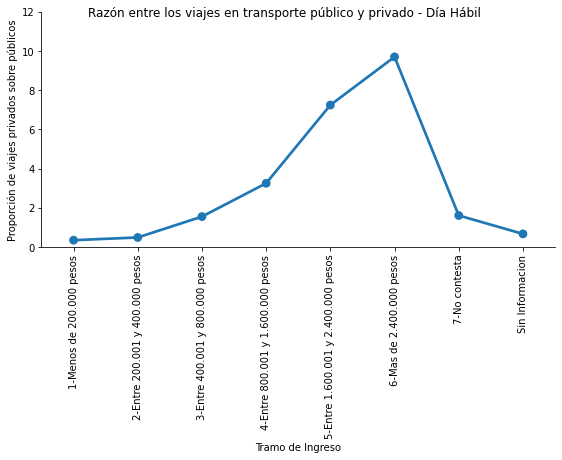

In [ ]:
g = sns.catplot(x="TramoIngreso", y="n_viajes",
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Tramo de Ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,12))

fig.tight_layout()

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día No Hábil')
df = viajes_privado_nohabiles.groupby(['TramoIngreso']).agg(n_viajes = ('PONDERADOR_CALIBRADO_VIAJES', 'sum')) / viajes_publico_nohabiles.groupby(['TramoIngreso']).agg(n_viajes = ('PONDERADOR_CALIBRADO_VIAJES', 'sum'))
df = df.reset_index()
df

Razón entre los viajes en transporte público y privado - Día No Hábil


TramoIngreso   n_viajes
0             1-Menos de 200.000 pesos   0.641032
1      2-Entre 200.001 y 400.000 pesos   0.806185
2      3-Entre 400.001 y 800.000 pesos   1.865583
3    4-Entre 800.001 y 1.600.000 pesos   7.224219
4  5-Entre 1.600.001 y 2.400.000 pesos  37.363007
5             6-Mas de 2.400.000 pesos        NaN
6                        7-No contesta   2.213940
7                      Sin Informacion   1.293870

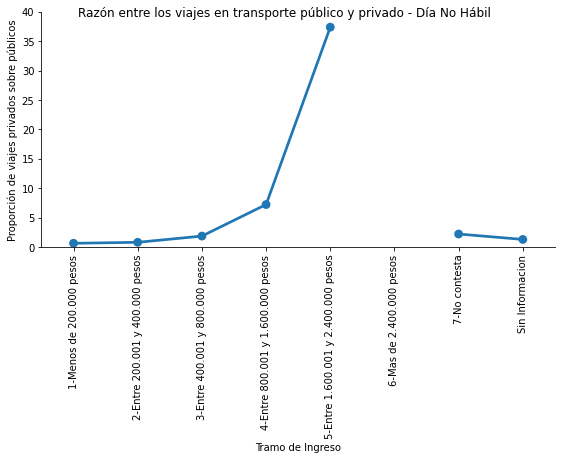

In [ ]:
g = sns.catplot(x="TramoIngreso", y="n_viajes",
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día No Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Tramo de Ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,40))

fig.tight_layout()

Para días hábiles y no hábiles, la razón entre viajes privados y públicos aumenta a medida que aumenta el tramo de ingreso. 

#### **¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?**

Las siguientes tablas y gráficos representan la partición modal de los viajes realizados en días hábiles, por clasificador socioeconómico.

In [ ]:
print('Partición Modal de los Viajes - Día Hábil')
df = viajes_habiles.groupby(['TramoIngreso', 'ModoAgregado']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df_norm = df.div(df.sum(axis=1), axis=0)
df_norm

Partición Modal de los Viajes - Día Hábil


ModoAgregado                             Auto  ...  Taxi Colectivo - Metro
TramoIngreso                                   ...                        
1-Menos de 200.000 pesos             0.105533  ...                0.002921
2-Entre 200.001 y 400.000 pesos      0.206071  ...                0.006256
3-Entre 400.001 y 800.000 pesos      0.430450  ...                0.009631
4-Entre 800.001 y 1.600.000 pesos    0.546023  ...                0.005615
5-Entre 1.600.001 y 2.400.000 pesos  0.589515  ...                     NaN
6-Mas de 2.400.000 pesos             0.655226  ...                0.000389
7-No contesta                        0.430532  ...                0.006082
Sin Informacion                      0.164833  ...                0.003993

[8 rows x 18 columns]

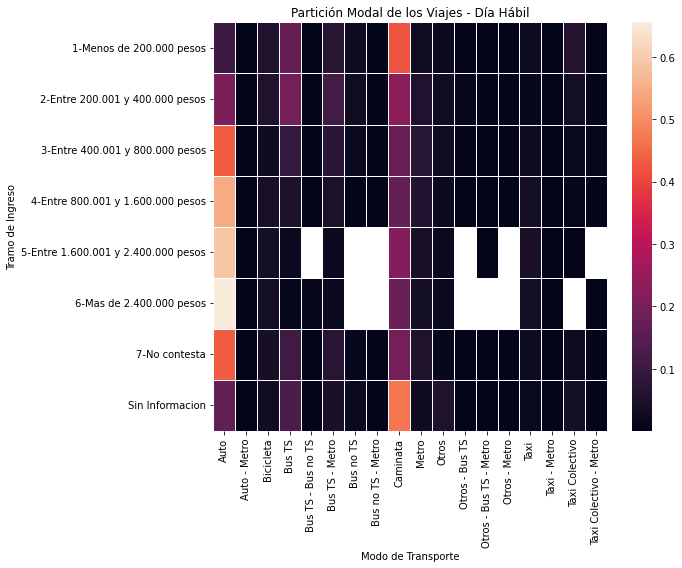

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Partición Modal de los Viajes - Día No Hábil')
df = viajes_nohabiles.groupby(['TramoIngreso', 'ModoAgregado']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df_norm =df.div(df.sum(axis=1), axis=0)
df_norm

Partición Modal de los Viajes - Día No Hábil


ModoAgregado                             Auto  ...  Taxi Colectivo - Metro
TramoIngreso                                   ...                        
1-Menos de 200.000 pesos             0.176788  ...                0.003211
2-Entre 200.001 y 400.000 pesos      0.244448  ...                0.002913
3-Entre 400.001 y 800.000 pesos      0.431296  ...                0.002793
4-Entre 800.001 y 1.600.000 pesos    0.760003  ...                0.000277
5-Entre 1.600.001 y 2.400.000 pesos  0.725774  ...                     NaN
6-Mas de 2.400.000 pesos             0.877181  ...                     NaN
7-No contesta                        0.508518  ...                0.002876
Sin Informacion                      0.257123  ...                0.001542

[8 rows x 18 columns]

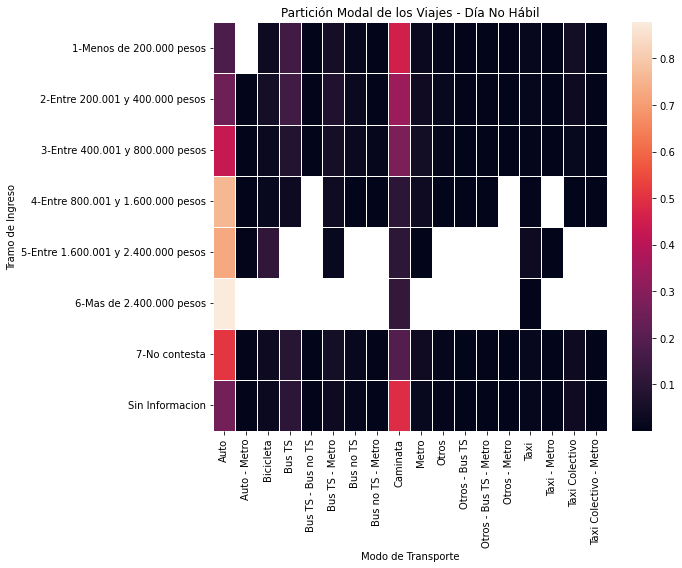

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

Durante días hábiles y no hábiles, los modos de transporte más utilizados son el auto, el cual aumenta a medida que aumenta el tramo de ingreso, y la caminata, que disminuye al aumentar el tramo de ingreso. También destaca el auto del bus TS y de bus TS - Metro durante días hábiles, en particular en los tramos más bajos.

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil')
df = viajes_habiles.groupby(['TramoIngreso', 'ModoPriPub']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)
df_norm

Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil


ModoPriPub                              Mixto  ...   Publico
TramoIngreso                                   ...          
1-Menos de 200.000 pesos             0.002095  ...  0.376504
2-Entre 200.001 y 400.000 pesos      0.007591  ...  0.465673
3-Entre 400.001 y 800.000 pesos      0.010896  ...  0.299661
4-Entre 800.001 y 1.600.000 pesos    0.007718  ...  0.181758
5-Entre 1.600.001 y 2.400.000 pesos  0.001990  ...  0.090129
6-Mas de 2.400.000 pesos             0.005551  ...  0.072640
7-No contesta                        0.008862  ...  0.286495
Sin Informacion                      0.004284  ...  0.268511

[8 rows x 5 columns]

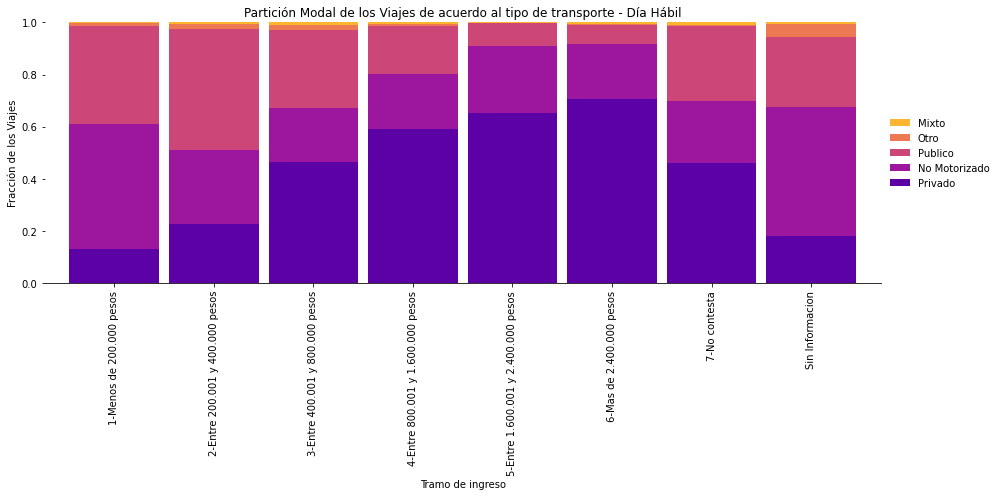

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(14, 7))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Tramo de ingreso")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil')
df = viajes_nohabiles.groupby(['TramoIngreso', 'ModoPriPub']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)
df_norm

Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil


ModoPriPub                              Mixto  ...   Publico
TramoIngreso                                   ...          
1-Menos de 200.000 pesos             0.004560  ...  0.306783
2-Entre 200.001 y 400.000 pesos      0.005574  ...  0.330268
3-Entre 400.001 y 800.000 pesos      0.003448  ...  0.241482
4-Entre 800.001 y 1.600.000 pesos    0.002763  ...  0.106418
5-Entre 1.600.001 y 2.400.000 pesos  0.009085  ...  0.020222
6-Mas de 2.400.000 pesos                  NaN  ...       NaN
7-No contesta                        0.007497  ...  0.237453
Sin Informacion                      0.005207  ...  0.208326

[8 rows x 5 columns]

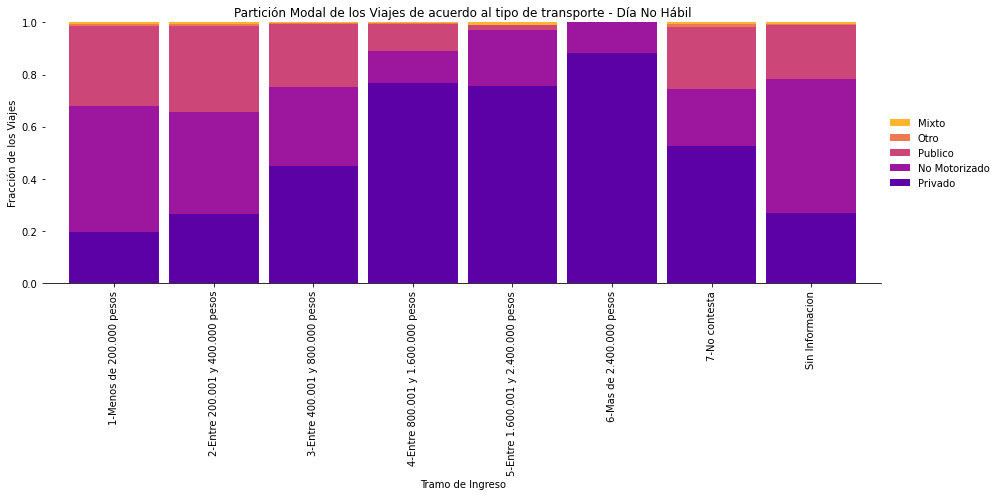

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(14, 7))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Tramo de Ingreso")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

Para tipo de transporte, se ve una disminución del uso del transporte público en general cuando se comparan días hábiles y no hábiles, y se ve que la fracción de viajes privados aumenta al aumentar el tramo de ingreso.

### Parte II: Indicadores de Tiempo de Viajes

En esta segunda parte, responderemos algunas preguntas respecto a indicadores de tiempo de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:
1. ¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?
2. ¿Cuál es el tiempo promedio de viaje en hora punta de mañana?
3. ¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?
4. ¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?

In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

In [ ]:
viajes_habiles= viajes_habiles[~viajes_habiles.TiempoViaje.isna()]
viajes_nohabiles= viajes_nohabiles[~viajes_nohabiles.TiempoViaje.isna()]

#### **¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?**

A continuación, se representa el promedio y mediana en minutos de viaje por modo y tipo de transporte, en días hábiles y no hábiles, por clasificador socioeconómico.



In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por modo - Dia Hábil


ModoAgregado                              Auto  ...  Taxi Colectivo - Metro
TramoIngreso                                    ...                        
1-Menos de 200.000 pesos             28.704572  ...               74.586490
2-Entre 200.001 y 400.000 pesos      35.241426  ...               75.851883
3-Entre 400.001 y 800.000 pesos      34.916003  ...               75.041093
4-Entre 800.001 y 1.600.000 pesos    31.839492  ...               60.182088
5-Entre 1.600.001 y 2.400.000 pesos  37.554193  ...                     NaN
6-Mas de 2.400.000 pesos             34.526555  ...               53.692644
7-No contesta                        31.273361  ...               77.596863
Sin Informacion                      25.291268  ...               76.583687

[8 rows x 18 columns]

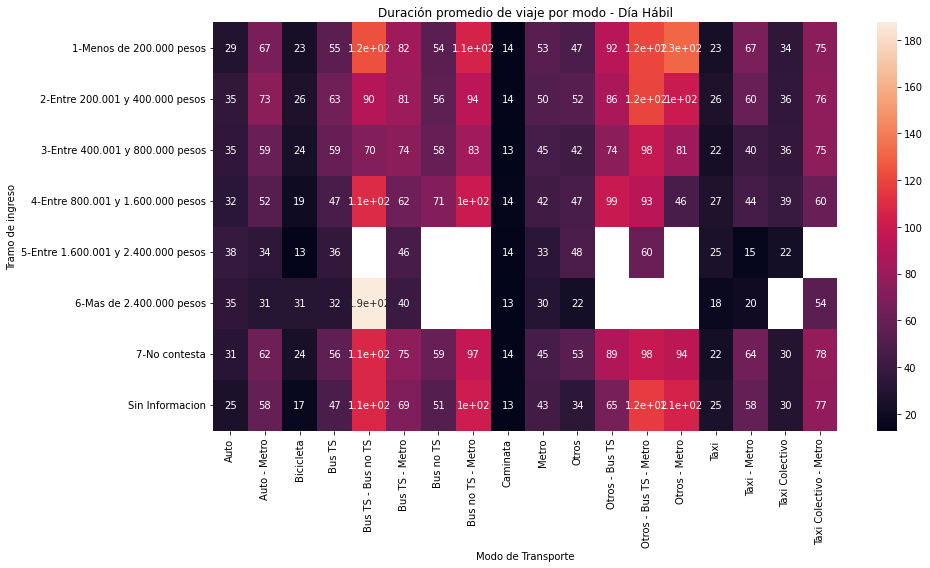

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por modo - Dia Hábil


ModoAgregado                         Auto  ...  Taxi Colectivo - Metro
TramoIngreso                               ...                        
1-Menos de 200.000 pesos             20.0  ...                    75.0
2-Entre 200.001 y 400.000 pesos      30.0  ...                    68.0
3-Entre 400.001 y 800.000 pesos      30.0  ...                    70.0
4-Entre 800.001 y 1.600.000 pesos    30.0  ...                    60.0
5-Entre 1.600.001 y 2.400.000 pesos  30.0  ...                     NaN
6-Mas de 2.400.000 pesos             30.0  ...                    60.0
7-No contesta                        25.0  ...                    70.0
Sin Informacion                      20.0  ...                    70.0

[8 rows x 18 columns]

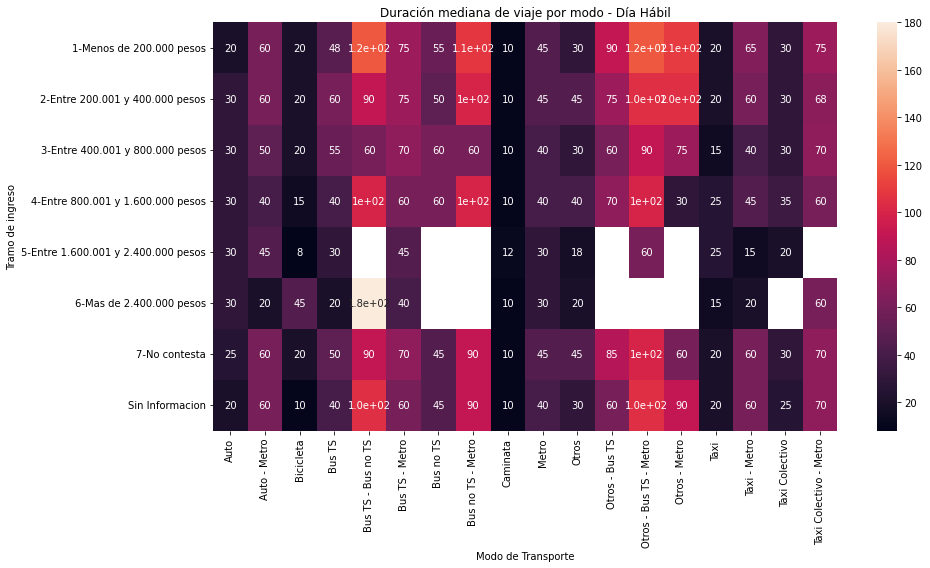

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia No Hábil')
df = viajes_nohabiles.groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por modo - Dia No Hábil


ModoAgregado                              Auto  ...  Taxi Colectivo - Metro
TramoIngreso                                    ...                        
1-Menos de 200.000 pesos             30.660965  ...               67.209453
2-Entre 200.001 y 400.000 pesos      32.580428  ...               68.571700
3-Entre 400.001 y 800.000 pesos      33.521962  ...               68.136922
4-Entre 800.001 y 1.600.000 pesos    29.036828  ...               69.021280
5-Entre 1.600.001 y 2.400.000 pesos  23.021835  ...                     NaN
6-Mas de 2.400.000 pesos             39.392996  ...                     NaN
7-No contesta                        27.469457  ...               42.798102
Sin Informacion                      29.640461  ...               44.826716

[8 rows x 18 columns]

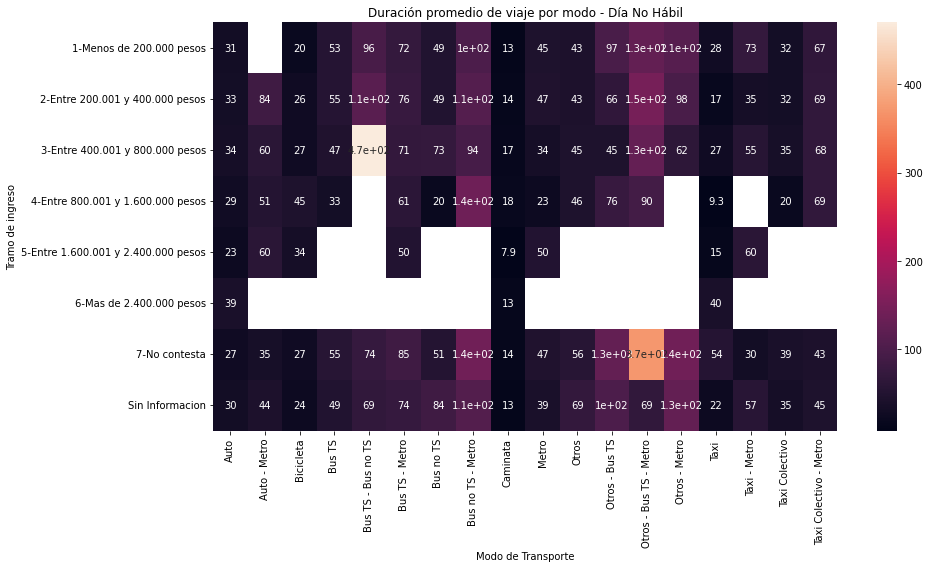

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia No Hábil')
df = viajes_nohabiles.groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por modo - Dia No Hábil


ModoAgregado                         Auto  ...  Taxi Colectivo - Metro
TramoIngreso                               ...                        
1-Menos de 200.000 pesos             20.0  ...                    60.0
2-Entre 200.001 y 400.000 pesos      20.0  ...                    60.0
3-Entre 400.001 y 800.000 pesos      30.0  ...                    60.0
4-Entre 800.001 y 1.600.000 pesos    20.0  ...                    60.0
5-Entre 1.600.001 y 2.400.000 pesos  15.0  ...                     NaN
6-Mas de 2.400.000 pesos             30.0  ...                     NaN
7-No contesta                        20.0  ...                    40.0
Sin Informacion                      20.0  ...                    45.0

[8 rows x 18 columns]

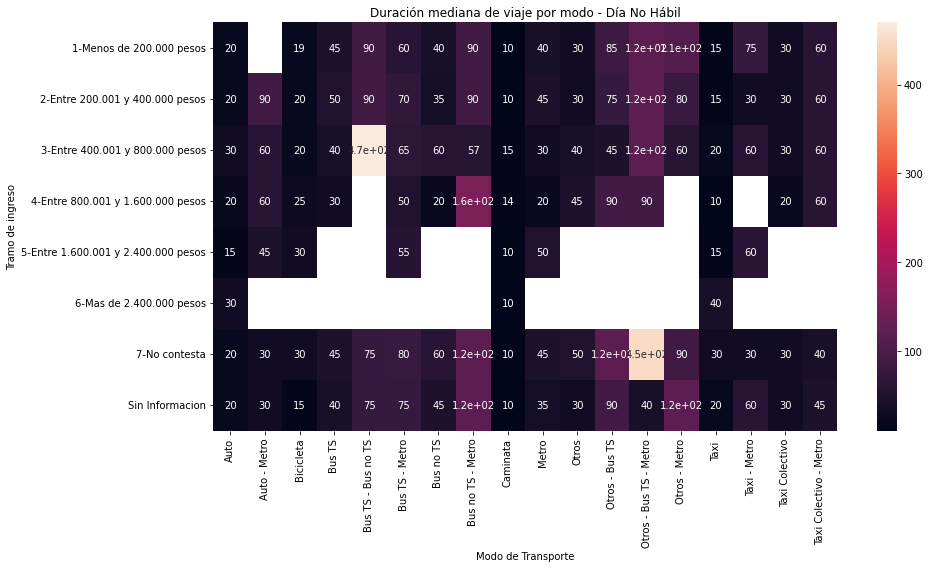

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de ingreso")

fig.tight_layout()

Durante días hábiles y no hábiles, se observa que los tiempos promedios de viaje más altos corresponden a los modos asociados a bus TS, bus no TS y algunas combinaciones con el uso del metro, mientras que los viajes con duraciones más cortas se realizan en auto, bicicleta, caminata y taxi.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(['TramoIngreso', 'ModoPriPub']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


ModoPriPub                               Mixto  ...    Publico
TramoIngreso                                    ...           
1-Menos de 200.000 pesos             87.257352  ...  58.007471
2-Entre 200.001 y 400.000 pesos      83.771570  ...  65.783489
3-Entre 400.001 y 800.000 pesos      64.485869  ...  60.578883
4-Entre 800.001 y 1.600.000 pesos    63.080231  ...  51.547453
5-Entre 1.600.001 y 2.400.000 pesos  51.462768  ...  35.850765
6-Mas de 2.400.000 pesos             29.938766  ...  56.854914
7-No contesta                        69.020735  ...  59.200812
Sin Informacion                      80.242362  ...  50.341146

[8 rows x 5 columns]

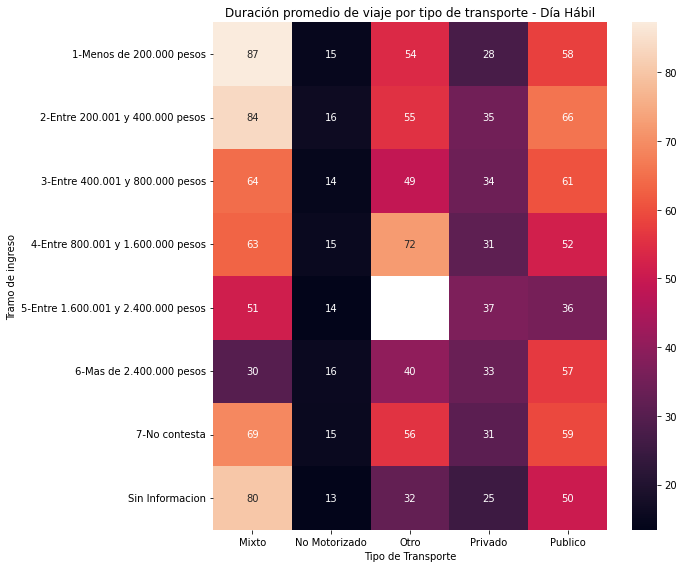

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Tramo de ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(['TramoIngreso', 'ModoPriPub']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil


ModoPriPub                           Mixto  No Motorizado  ...  Privado  Publico
TramoIngreso                                               ...                  
1-Menos de 200.000 pesos              75.0           10.0  ...     20.0     50.0
2-Entre 200.001 y 400.000 pesos       75.0           10.0  ...     30.0     60.0
3-Entre 400.001 y 800.000 pesos       55.0           10.0  ...     30.0     60.0
4-Entre 800.001 y 1.600.000 pesos     60.0           10.0  ...     29.0     45.0
5-Entre 1.600.001 y 2.400.000 pesos   75.0           12.0  ...     30.0     30.0
6-Mas de 2.400.000 pesos              20.0           12.0  ...     30.0     30.0
7-No contesta                         60.0           10.0  ...     25.0     55.0
Sin Informacion                       60.0           10.0  ...     20.0     45.0

[8 rows x 5 columns]

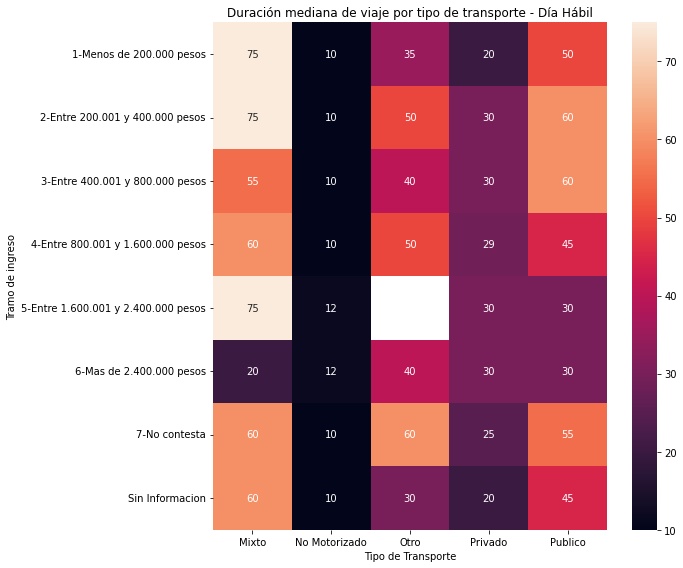

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Tramo de ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia No Hábil')
df = viajes_nohabiles.groupby(['TramoIngreso', 'ModoPriPub']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por tipo de transporte - Dia No Hábil


ModoPriPub                                Mixto  ...    Publico
TramoIngreso                                     ...           
1-Menos de 200.000 pesos              98.252873  ...  54.942803
2-Entre 200.001 y 400.000 pesos       77.024018  ...  58.615864
3-Entre 400.001 y 800.000 pesos       56.059608  ...  56.599337
4-Entre 800.001 y 1.600.000 pesos     60.824957  ...  40.839249
5-Entre 1.600.001 y 2.400.000 pesos   60.000000  ...  50.217376
6-Mas de 2.400.000 pesos                    NaN  ...        NaN
7-No contesta                         37.087750  ...  65.341786
Sin Informacion                      112.571546  ...  52.580696

[8 rows x 5 columns]

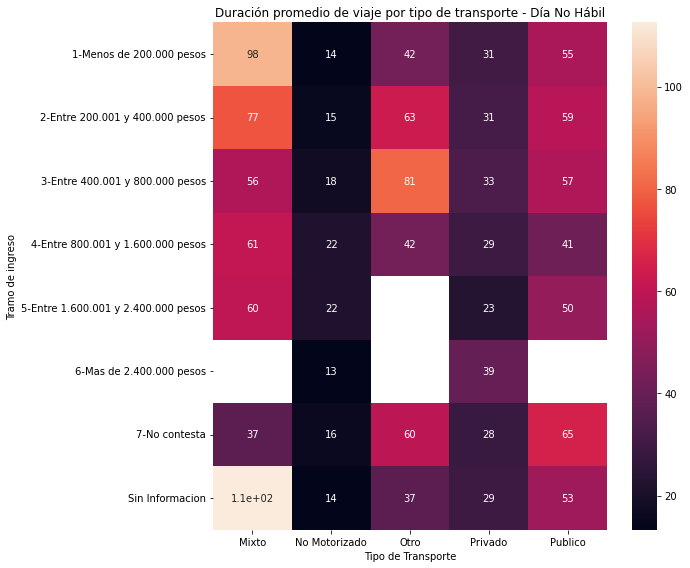

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por tipo de transporte - Día No Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Tramo de ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte - Dia No Hábil')
df = viajes_nohabiles.groupby(['TramoIngreso', 'ModoPriPub']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por tipo de transporte - Dia No Hábil


ModoPriPub                           Mixto  No Motorizado  ...  Privado  Publico
TramoIngreso                                               ...                  
1-Menos de 200.000 pesos             105.0           10.0  ...     20.0     45.0
2-Entre 200.001 y 400.000 pesos       75.0           10.0  ...     20.0     50.0
3-Entre 400.001 y 800.000 pesos       60.0           15.0  ...     30.0     45.0
4-Entre 800.001 y 1.600.000 pesos     60.0           14.0  ...     20.0     30.0
5-Entre 1.600.001 y 2.400.000 pesos   60.0           15.0  ...     15.0     50.0
6-Mas de 2.400.000 pesos               NaN           10.0  ...     30.0      NaN
7-No contesta                         30.0           10.0  ...     20.0     53.0
Sin Informacion                       87.0           10.0  ...     20.0     45.0

[8 rows x 5 columns]

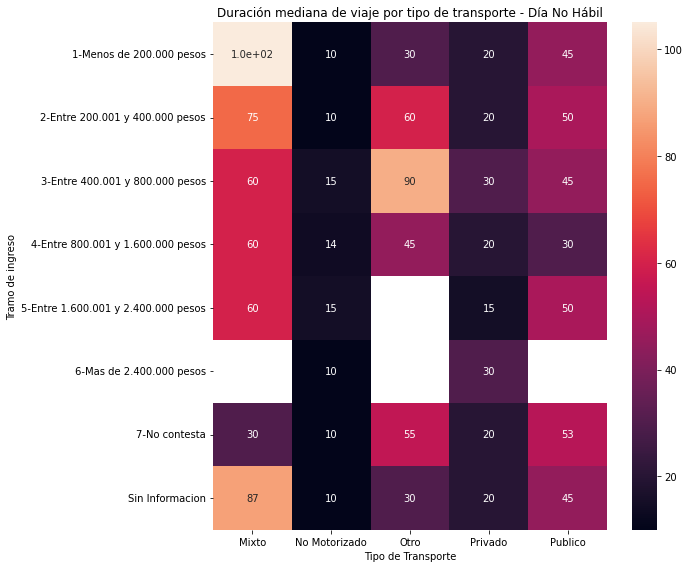

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por tipo de transporte - Día No Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Tramo de ingreso")

fig.tight_layout()

Al analizar por tipo de transporte, para días hábiles y no hábiles, vemos que los tiempos promedios para transporte no motorizado son los más bajos, mientras que los transportes mixtos tienen las duraciones más altas, sobre todo en los tramos más bajos de ingreso.

#### **¿Cuál es el tiempo promedio de viaje en hora punta de mañana?**

A continuación, se presentan los resultados para el promedio y mediana en minutos de viaje por modo y tipo de transporte, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil


ModoAgregado                              Auto  ...  Taxi Colectivo - Metro
TramoIngreso                                    ...                        
1-Menos de 200.000 pesos             29.655342  ...               67.673012
2-Entre 200.001 y 400.000 pesos      38.961406  ...               76.109861
3-Entre 400.001 y 800.000 pesos      41.227930  ...               81.478815
4-Entre 800.001 y 1.600.000 pesos    39.751607  ...               68.635414
5-Entre 1.600.001 y 2.400.000 pesos  37.664314  ...                     NaN
6-Mas de 2.400.000 pesos             37.495994  ...               53.692644
7-No contesta                        33.865538  ...               76.403475
Sin Informacion                      23.768215  ...               80.862538

[8 rows x 18 columns]

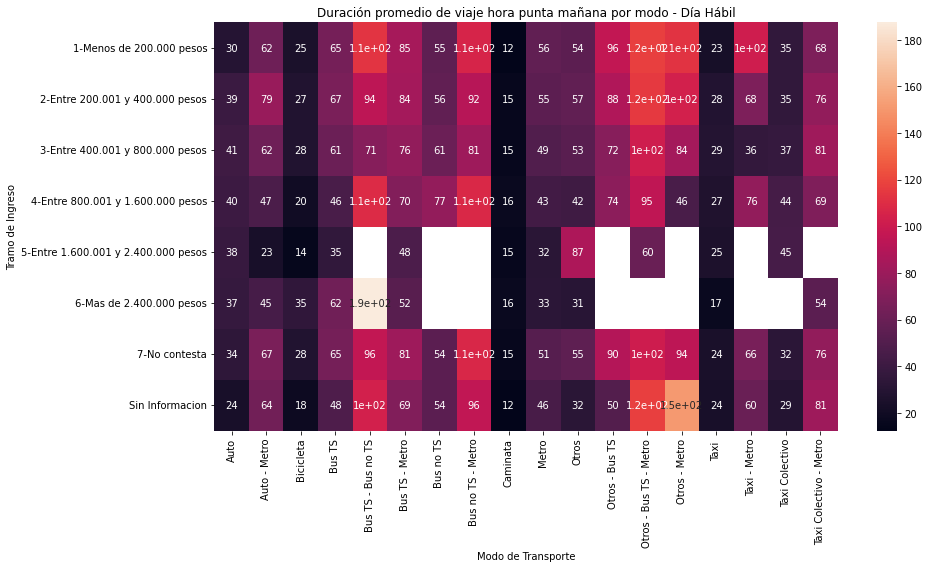

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil


ModoAgregado                         Auto  ...  Taxi Colectivo - Metro
TramoIngreso                               ...                        
1-Menos de 200.000 pesos             20.0  ...                    80.0
2-Entre 200.001 y 400.000 pesos      30.0  ...                    65.0
3-Entre 400.001 y 800.000 pesos      35.0  ...                    80.0
4-Entre 800.001 y 1.600.000 pesos    30.0  ...                    70.0
5-Entre 1.600.001 y 2.400.000 pesos  30.0  ...                     NaN
6-Mas de 2.400.000 pesos             30.0  ...                    60.0
7-No contesta                        30.0  ...                    70.0
Sin Informacion                      20.0  ...                    70.0

[8 rows x 18 columns]

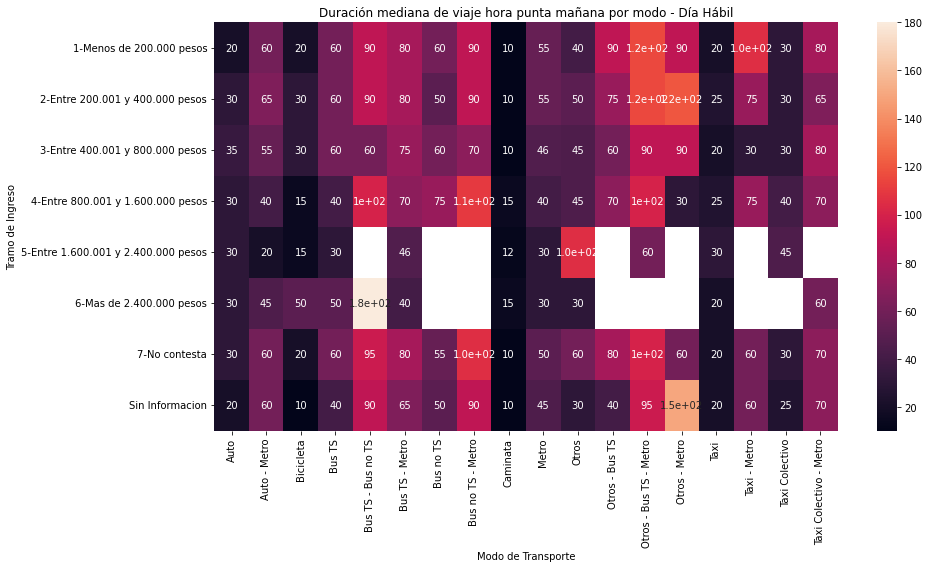

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia No Hábil')
df = viajes_nohabiles[viajes_nohabiles.PICO_NOHABIL=='Si'].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por modo en hora punta - Dia No Hábil


ModoAgregado                              Auto  ...  Taxi Colectivo - Metro
TramoIngreso                                    ...                        
1-Menos de 200.000 pesos             28.103595  ...               64.792055
2-Entre 200.001 y 400.000 pesos      35.847448  ...               67.167725
3-Entre 400.001 y 800.000 pesos      40.927043  ...               75.000000
4-Entre 800.001 y 1.600.000 pesos    36.688892  ...               69.021280
5-Entre 1.600.001 y 2.400.000 pesos  41.511600  ...                     NaN
6-Mas de 2.400.000 pesos             40.058710  ...                     NaN
7-No contesta                        39.080133  ...               53.696020
Sin Informacion                      33.102404  ...               54.792557

[8 rows x 18 columns]

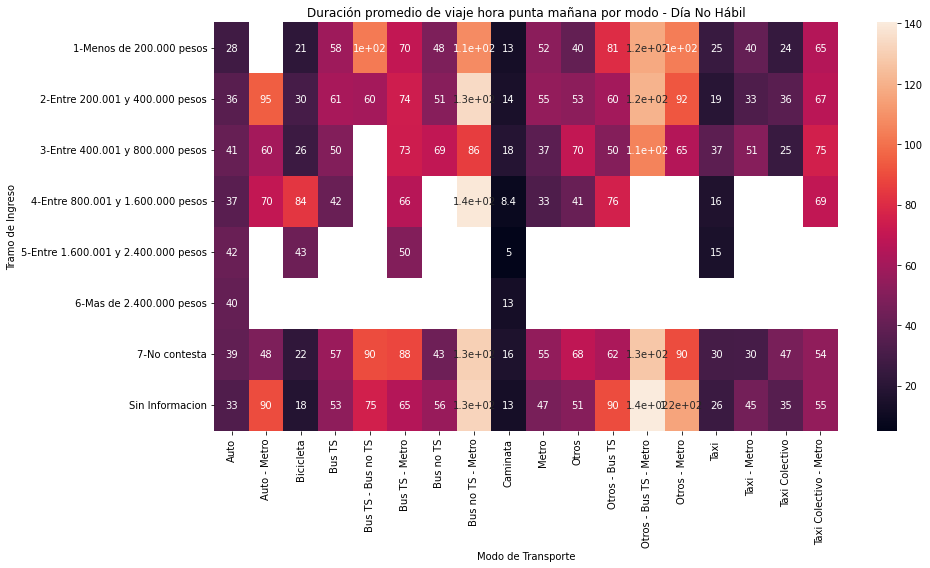

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia No Hábil')
df = viajes_nohabiles[viajes_nohabiles.PICO_NOHABIL=='Si'].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por modo en hora punta - Dia No Hábil


ModoAgregado                         Auto  ...  Taxi Colectivo - Metro
TramoIngreso                               ...                        
1-Menos de 200.000 pesos             20.0  ...                    45.0
2-Entre 200.001 y 400.000 pesos      30.0  ...                    55.0
3-Entre 400.001 y 800.000 pesos      30.0  ...                    75.0
4-Entre 800.001 y 1.600.000 pesos    30.0  ...                    60.0
5-Entre 1.600.001 y 2.400.000 pesos  45.0  ...                     NaN
6-Mas de 2.400.000 pesos             30.0  ...                     NaN
7-No contesta                        27.0  ...                    55.0
Sin Informacion                      30.0  ...                    60.0

[8 rows x 18 columns]

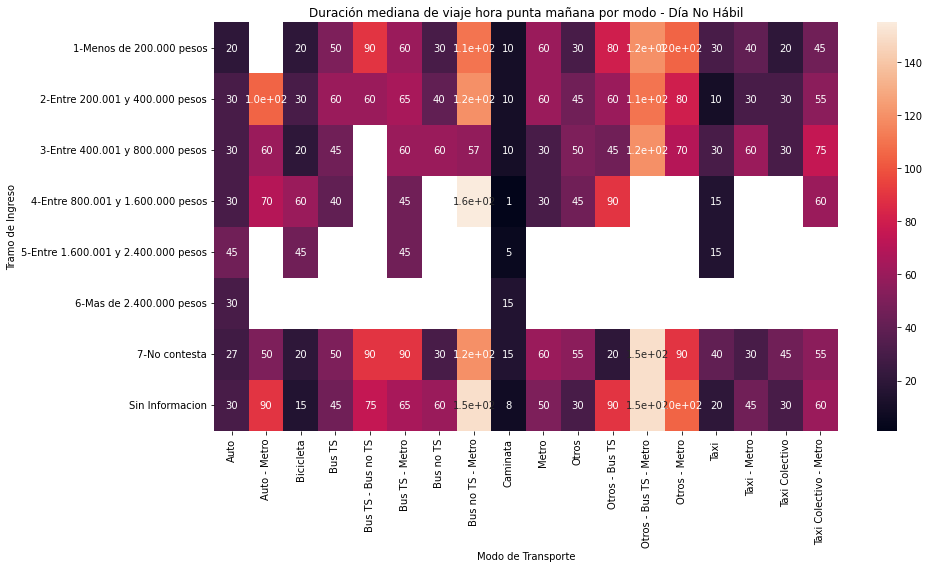

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

Para días hábiles, los medios de transporte con mayores duración de viaje en hora punta de mañana son combinaciones de transporte con Metro, o combinaciones de Bus TS con Bus No TS u otros. Para días no hábiles, nuevamente las combinaciones con Metro tienen altas duraciones de viaje, en particular Bus no TS - Metro, Otros - Metro, Otros - Bus TS - Metro. Los modos con viajes de duraciones más cortas son Caminata, Taxi y Bicicleta.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(['TramoIngreso', 'ModoPriPub']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


ModoPriPub                               Mixto  ...    Publico
TramoIngreso                                    ...           
1-Menos de 200.000 pesos             93.094412  ...  67.134504
2-Entre 200.001 y 400.000 pesos      86.269214  ...  70.350953
3-Entre 400.001 y 800.000 pesos      68.332403  ...  63.812887
4-Entre 800.001 y 1.600.000 pesos    71.842029  ...  54.064898
5-Entre 1.600.001 y 2.400.000 pesos  23.412485  ...  35.795789
6-Mas de 2.400.000 pesos             45.000000  ...  80.684559
7-No contesta                        76.440382  ...  68.055934
Sin Informacion                      77.424180  ...  53.113466

[8 rows x 5 columns]

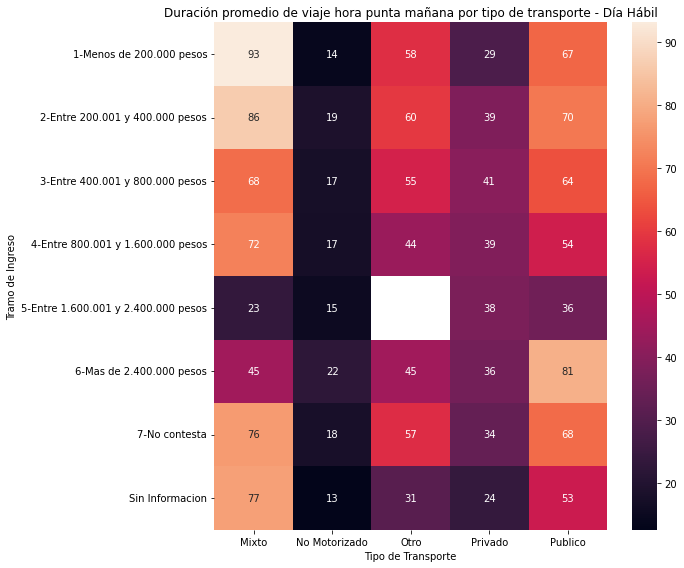

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(['TramoIngreso', 'ModoPriPub']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


ModoPriPub                           Mixto  No Motorizado  ...  Privado  Publico
TramoIngreso                                               ...                  
1-Menos de 200.000 pesos              90.0           10.0  ...     20.0     60.0
2-Entre 200.001 y 400.000 pesos       75.0           15.0  ...     30.0     60.0
3-Entre 400.001 y 800.000 pesos       55.0           10.0  ...     30.0     60.0
4-Entre 800.001 y 1.600.000 pesos     70.0           15.0  ...     30.0     45.0
5-Entre 1.600.001 y 2.400.000 pesos   20.0           12.0  ...     30.0     30.0
6-Mas de 2.400.000 pesos              45.0           15.0  ...     30.0     40.0
7-No contesta                         70.0           15.0  ...     30.0     60.0
Sin Informacion                       60.0           10.0  ...     20.0     45.0

[8 rows x 5 columns]

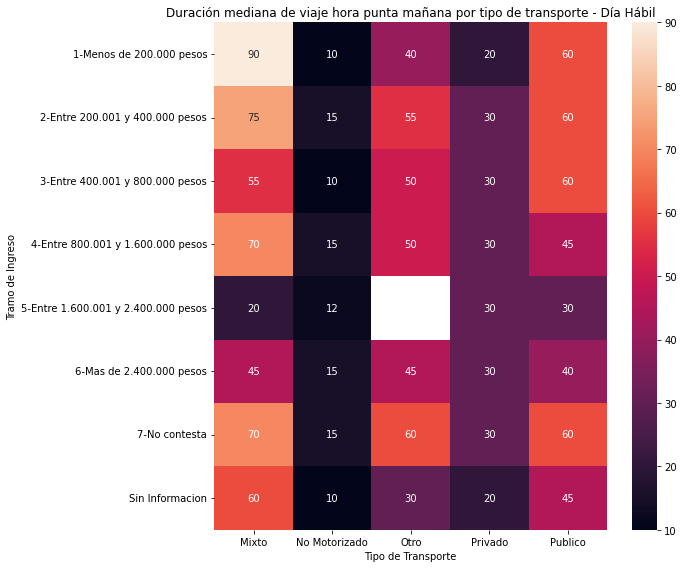

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia No Hábil')
df = viajes_nohabiles[(viajes_nohabiles.PICO_NOHABIL=='Si')].groupby(['TramoIngreso', 'ModoPriPub']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia No Hábil


ModoPriPub                               Mixto  ...    Publico
TramoIngreso                                    ...           
1-Menos de 200.000 pesos             91.615137  ...  59.745020
2-Entre 200.001 y 400.000 pesos      73.440928  ...  63.984527
3-Entre 400.001 y 800.000 pesos      52.193035  ...  57.944491
4-Entre 800.001 y 1.600.000 pesos    70.000000  ...  53.368653
5-Entre 1.600.001 y 2.400.000 pesos        NaN  ...  49.871482
6-Mas de 2.400.000 pesos                   NaN  ...        NaN
7-No contesta                        52.232968  ...  64.625593
Sin Informacion                      99.347536  ...  52.981081

[8 rows x 5 columns]

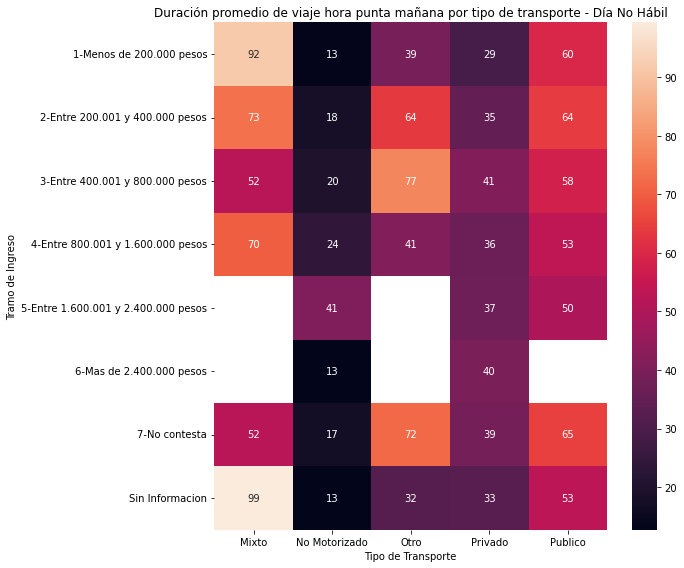

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por tipo de transporte - Día No Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia No Hábil')
df = viajes_nohabiles[(viajes_nohabiles.PICO_NOHABIL=='Si')].groupby(['TramoIngreso', 'ModoPriPub']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia No Hábil


ModoPriPub                           Mixto  No Motorizado  ...  Privado  Publico
TramoIngreso                                               ...                  
1-Menos de 200.000 pesos             105.0           10.0  ...     25.0     60.0
2-Entre 200.001 y 400.000 pesos       75.0           15.0  ...     30.0     60.0
3-Entre 400.001 y 800.000 pesos       60.0           15.0  ...     30.0     57.0
4-Entre 800.001 y 1.600.000 pesos     70.0           10.0  ...     30.0     40.0
5-Entre 1.600.001 y 2.400.000 pesos    NaN           35.0  ...     30.0     45.0
6-Mas de 2.400.000 pesos               NaN           15.0  ...     30.0      NaN
7-No contesta                         50.0           15.0  ...     28.0     60.0
Sin Informacion                      105.0           10.0  ...     30.0     45.0

[8 rows x 5 columns]

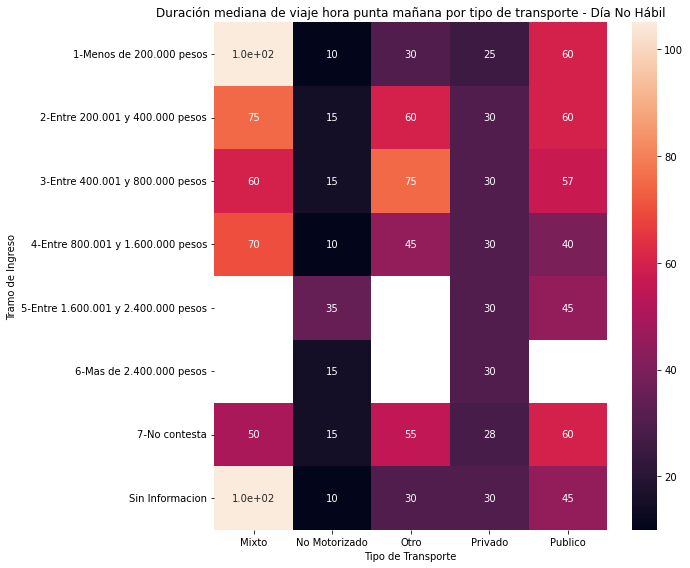

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por tipo de transporte - Día No Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

Para días hábiles y no hábiles, los viajes con menor duración en hora punta de mañana son los realizados en transporte no motorizado, y los de mayor duración son los realizados en transporte mixto (con duración máxima en el tramo de ingreso más bajo), seguido por transporte público.

#### **¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?**

A continuación, se presentan los resultados para duración promedio de viaje en hora punta de mañana en transporte público, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.ModoPriPub=='Publico')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'][mask].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje por modo en hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


ModoAgregado                            Bus TS  ...  Taxi Colectivo - Metro
TramoIngreso                                    ...                        
1-Menos de 200.000 pesos             64.605811  ...               67.673012
2-Entre 200.001 y 400.000 pesos      66.667478  ...               76.109861
3-Entre 400.001 y 800.000 pesos      60.714489  ...               81.478815
4-Entre 800.001 y 1.600.000 pesos    46.255893  ...               68.635414
5-Entre 1.600.001 y 2.400.000 pesos  35.012018  ...                     NaN
6-Mas de 2.400.000 pesos             62.348352  ...               53.692644
7-No contesta                        64.920900  ...               76.403475
Sin Informacion                      47.948346  ...               80.862538

[8 rows x 12 columns]

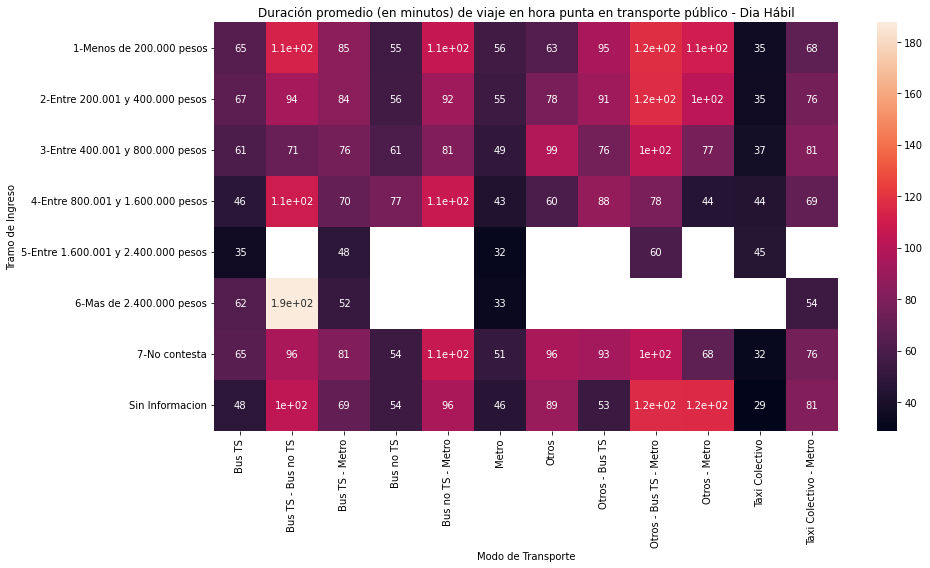

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.ModoPriPub=='Publico')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'][mask].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje por modo en hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


ModoAgregado                         Bus TS  ...  Taxi Colectivo - Metro
TramoIngreso                                 ...                        
1-Menos de 200.000 pesos               60.0  ...                    80.0
2-Entre 200.001 y 400.000 pesos        60.0  ...                    65.0
3-Entre 400.001 y 800.000 pesos        60.0  ...                    80.0
4-Entre 800.001 y 1.600.000 pesos      40.0  ...                    70.0
5-Entre 1.600.001 y 2.400.000 pesos    30.0  ...                     NaN
6-Mas de 2.400.000 pesos               50.0  ...                    60.0
7-No contesta                          60.0  ...                    70.0
Sin Informacion                        40.0  ...                    70.0

[8 rows x 12 columns]

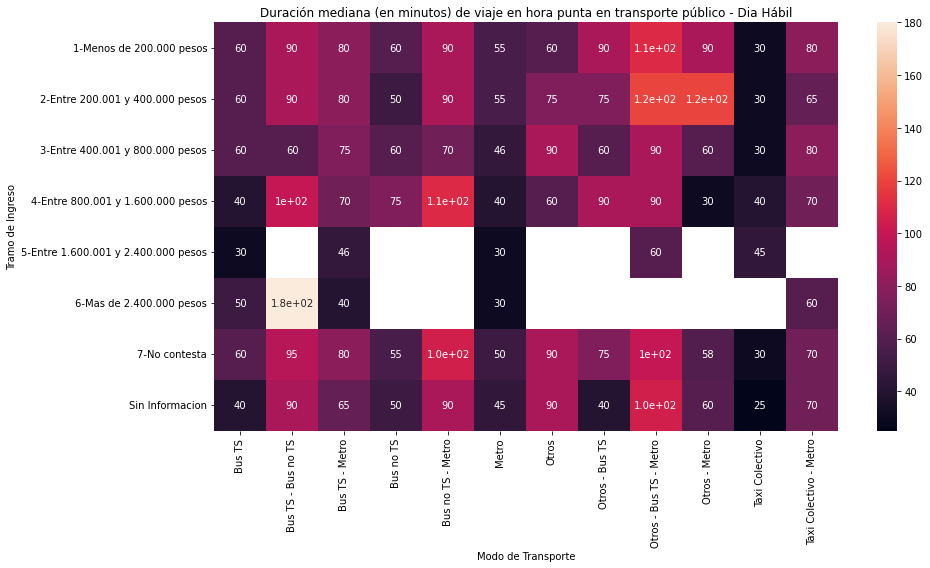

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje hora punta en transporte público - Dia No Hábil')
mask = (viajes_nohabiles.ModoPriPub=='Publico')
df = viajes_nohabiles[viajes_nohabiles.PICO_NOHABIL=='Si'][mask].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje hora punta en transporte público - Dia No Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


ModoAgregado                            Bus TS  ...  Taxi Colectivo - Metro
TramoIngreso                                    ...                        
1-Menos de 200.000 pesos             58.041185  ...               64.792055
2-Entre 200.001 y 400.000 pesos      61.173027  ...               67.167725
3-Entre 400.001 y 800.000 pesos      49.813542  ...               75.000000
4-Entre 800.001 y 1.600.000 pesos    41.740078  ...               69.021280
5-Entre 1.600.001 y 2.400.000 pesos        NaN  ...                     NaN
7-No contesta                        57.168391  ...               53.696020
Sin Informacion                      53.237153  ...               54.792557

[7 rows x 12 columns]

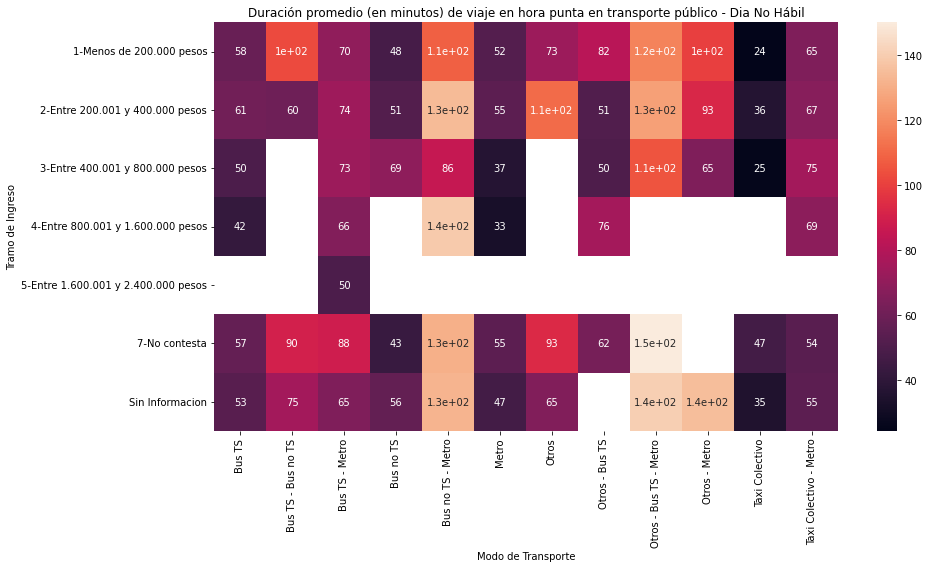

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje hora punta en transporte público - Dia No Hábil')
mask = (viajes_nohabiles.ModoPriPub=='Publico')
df = viajes_nohabiles[viajes_nohabiles.PICO_NOHABIL=='Si'][mask].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje hora punta en transporte público - Dia No Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


ModoAgregado                         Bus TS  ...  Taxi Colectivo - Metro
TramoIngreso                                 ...                        
1-Menos de 200.000 pesos               50.0  ...                    45.0
2-Entre 200.001 y 400.000 pesos        60.0  ...                    55.0
3-Entre 400.001 y 800.000 pesos        45.0  ...                    75.0
4-Entre 800.001 y 1.600.000 pesos      40.0  ...                    60.0
5-Entre 1.600.001 y 2.400.000 pesos     NaN  ...                     NaN
7-No contesta                          50.0  ...                    55.0
Sin Informacion                        45.0  ...                    60.0

[7 rows x 12 columns]

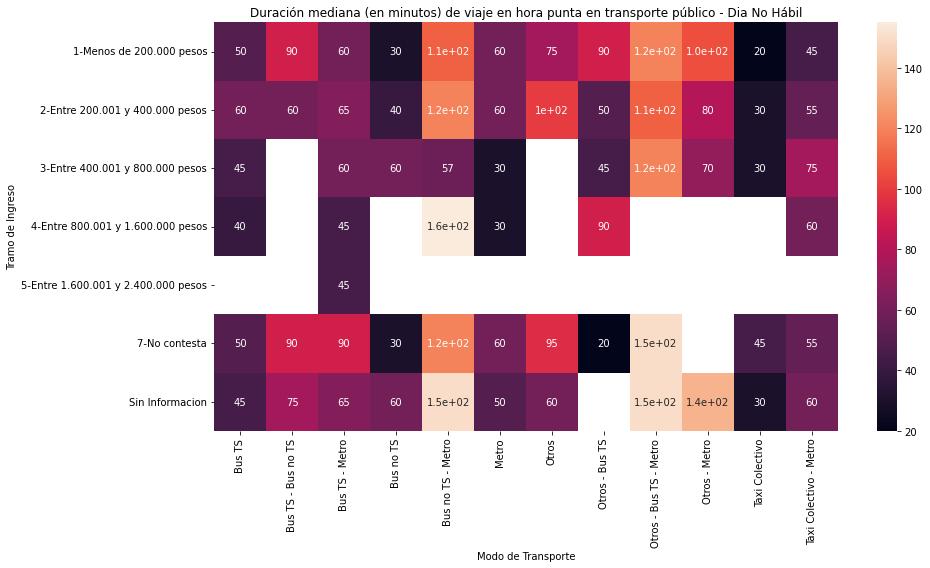

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

En días hábiles y no hábiles, las duraciones mayores de viaje en transporte público en hora punta de mañana son de las combinaciones de Bus TS - Bus no TS, Bus no TS - Metro, Otros - Bus TS - Metro y Otros - Metro, con estas dos últimas opciones con valores más altos en los tramos más bajos. Las duraciones más bajas corresponden a Taxi Colectivo a través de todos los tramos.

#### **¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?**

A continuación, se presentan los resultados de tiempo promedio de viaje al trabajo en transporte público, por clasificador socioeconómico.

In [ ]:
viajes_habiles.PropositoAgregado.unique()

array(['Otro', 'Trabajo', 'Estudio', 'Volver a casa'], dtype=object)

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.ModoPriPub=='Publico') & (viajes_habiles.PropositoAgregado=='Trabajo')
df = viajes_habiles[mask].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil


ModoAgregado                            Bus TS  ...  Taxi Colectivo - Metro
TramoIngreso                                    ...                        
1-Menos de 200.000 pesos             66.033342  ...               81.085138
2-Entre 200.001 y 400.000 pesos      65.894849  ...               77.536814
3-Entre 400.001 y 800.000 pesos      61.653001  ...               78.926681
4-Entre 800.001 y 1.600.000 pesos    47.680412  ...               63.405236
5-Entre 1.600.001 y 2.400.000 pesos  37.598248  ...                     NaN
6-Mas de 2.400.000 pesos             31.562753  ...               53.692644
7-No contesta                        62.156122  ...               64.979417
Sin Informacion                      77.405315  ...               86.390030

[8 rows x 12 columns]

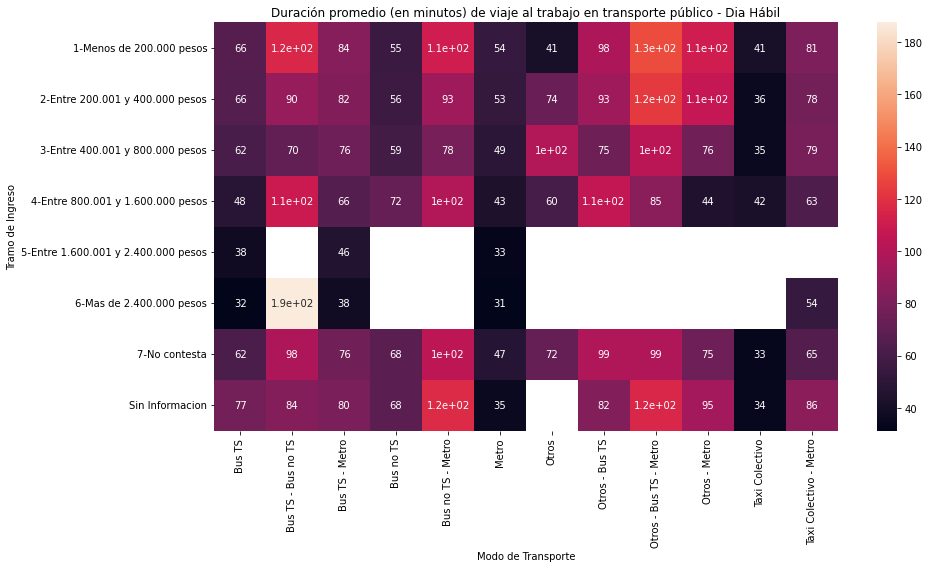

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.ModoPriPub=='Publico') & (viajes_habiles.PropositoAgregado=='Trabajo')
df = viajes_habiles[mask].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


ModoAgregado                         Bus TS  ...  Taxi Colectivo - Metro
TramoIngreso                                 ...                        
1-Menos de 200.000 pesos               60.0  ...                    80.0
2-Entre 200.001 y 400.000 pesos        60.0  ...                    70.0
3-Entre 400.001 y 800.000 pesos        60.0  ...                    80.0
4-Entre 800.001 y 1.600.000 pesos      40.0  ...                    60.0
5-Entre 1.600.001 y 2.400.000 pesos    45.0  ...                     NaN
6-Mas de 2.400.000 pesos               20.0  ...                    60.0
7-No contesta                          60.0  ...                    70.0
Sin Informacion                        65.0  ...                    85.0

[8 rows x 12 columns]

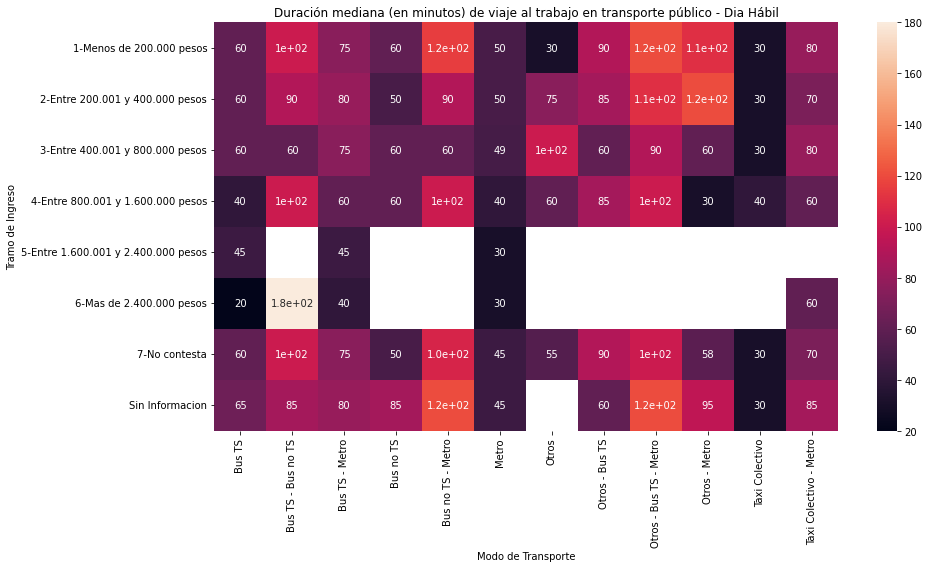

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia No Hábil')
mask = (viajes_nohabiles.ModoPriPub=='Publico') & (viajes_nohabiles.PropositoAgregado=='Trabajo')
df = viajes_nohabiles[mask].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_mean(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia No Hábil


ModoAgregado                            Bus TS  ...  Taxi Colectivo - Metro
TramoIngreso                                    ...                        
1-Menos de 200.000 pesos             60.692730  ...               60.412266
2-Entre 200.001 y 400.000 pesos      63.224952  ...               66.118256
3-Entre 400.001 y 800.000 pesos      49.758469  ...               69.713708
4-Entre 800.001 y 1.600.000 pesos    28.348049  ...               69.021280
5-Entre 1.600.001 y 2.400.000 pesos        NaN  ...                     NaN
7-No contesta                        63.674582  ...               50.824522
Sin Informacion                      86.508958  ...                     NaN

[7 rows x 12 columns]

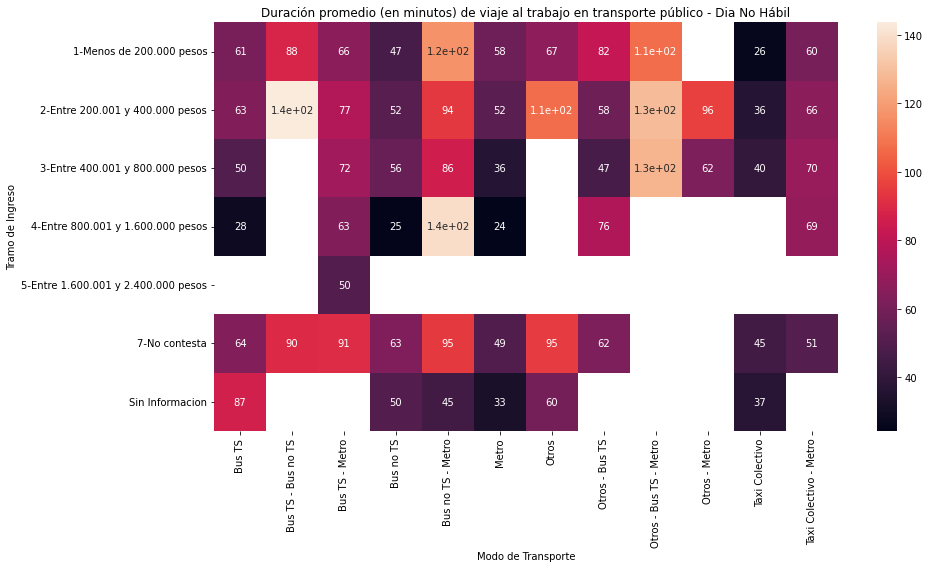

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia No Hábil')
mask = (viajes_nohabiles.ModoPriPub=='Publico') & (viajes_nohabiles.PropositoAgregado=='Trabajo')
df = viajes_nohabiles[mask].groupby(['TramoIngreso', 'ModoAgregado']).apply(lambda x: weighted_median(x, 'TiempoViaje', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
df

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia No Hábil


ModoAgregado                         Bus TS  ...  Taxi Colectivo - Metro
TramoIngreso                                 ...                        
1-Menos de 200.000 pesos               60.0  ...                    45.0
2-Entre 200.001 y 400.000 pesos        60.0  ...                    60.0
3-Entre 400.001 y 800.000 pesos        45.0  ...                    60.0
4-Entre 800.001 y 1.600.000 pesos      30.0  ...                    60.0
5-Entre 1.600.001 y 2.400.000 pesos     NaN  ...                     NaN
7-No contesta                          60.0  ...                    50.0
Sin Informacion                        60.0  ...                     NaN

[7 rows x 12 columns]

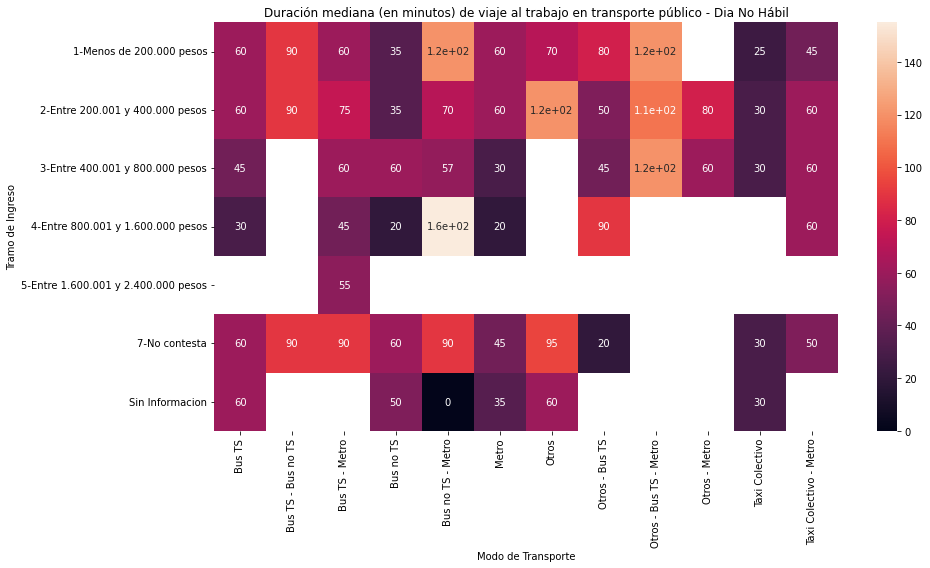

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Tramo de Ingreso")

fig.tight_layout()

En días hábiles y no hábiles, los modos con mayor duración de viaje al trabajo en transporte público son de las combinaciones de Bus TS - Bus no TS, Bus no TS - Metro y Otros - Bus TS - Metro, con fluctuaciones de variación a través de los tramos de ingreso. Las duraciones más bajas corresponden a Taxi Colectivo a través de todos los tramos.

### Parte III: Indicadores de Distancia de Viajes
1. Distancia de viajes en auto (histograma de viajes por km)
2.Distancia de viajes en transporte público (histograma de viajes por km)
3.Distancia de viajes por motivo estudio (histograma de viajes por km)
4.Distancia de viajes por motivo al trabajo (histograma de viajes por km)
5.Viajes interzonales como intrazonales


En esta sección, se presentarán los indicadores de distancia de viajes durante días hábiles.

In [ ]:
viajes_habiles = viajes_habiles[(viajes_habiles['DistManhattan'].between(500, 45000))]
viajes_nohabiles = viajes_nohabiles[(viajes_nohabiles['DistManhattan'].between(500, 45000))]
viajes_personas = viajes_personas[(viajes_personas['DistManhattan'].between(500, 45000))]


#### **Distancia de viajes en auto (histograma de viajes por km)**

Distancia de viajes en auto - Día Hábil


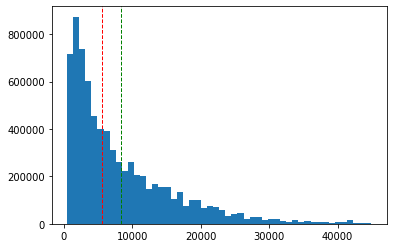

In [ ]:
from matplotlib.pyplot import hist
print('Distancia de viajes en auto - Día Hábil')
mask = (viajes_habiles.ModoAgregado == 'Auto')
df = viajes_habiles[mask].groupby('DistManhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('DistManhattan')
hist(df.DistManhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_habiles[mask].groupby('Viaje').apply(lambda x: weighted_mean(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('Viaje').apply(lambda x: weighted_median(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

Distancia de viajes en auto - Día No Hábil


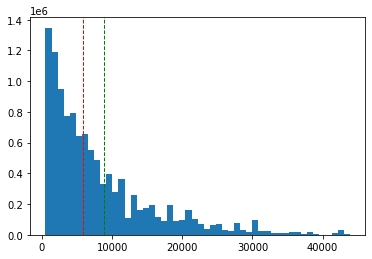

In [ ]:
print('Distancia de viajes en auto - Día No Hábil')
mask = (viajes_nohabiles.ModoAgregado == 'Auto')
df = viajes_nohabiles[mask].groupby('DistManhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('DistManhattan')
hist(df.DistManhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_nohabiles[mask].groupby('Viaje').apply(lambda x: weighted_mean(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_nohabiles[mask].groupby('Viaje').apply(lambda x: weighted_median(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes en transporte público**

Distancia de viajes en transporte público - Día Hábil


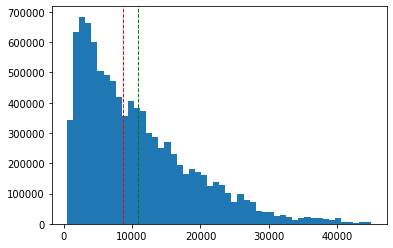

In [ ]:
print('Distancia de viajes en transporte público - Día Hábil')
mask = (viajes_habiles.ModoPriPub == 'Publico')
df = viajes_habiles[mask].groupby('DistManhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('DistManhattan')
hist(df.DistManhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_habiles[mask].groupby('Viaje').apply(lambda x: weighted_mean(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('Viaje').apply(lambda x: weighted_median(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

Distancia de viajes en transporte público - Día No Hábil


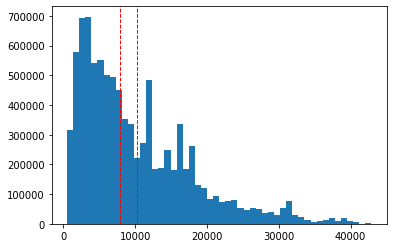

In [ ]:
print('Distancia de viajes en transporte público - Día No Hábil')
mask = (viajes_nohabiles.ModoPriPub == 'Publico')
df = viajes_nohabiles[mask].groupby('DistManhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('DistManhattan')
hist(df.DistManhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_nohabiles[mask].groupby('Viaje').apply(lambda x: weighted_mean(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_nohabiles[mask].groupby('Viaje').apply(lambda x: weighted_median(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo estudio**

Distancia de viajes con motivo de estudio


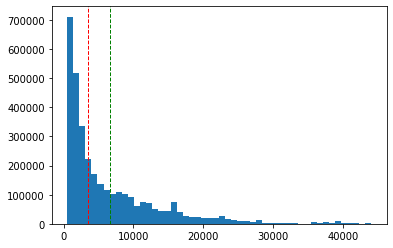

In [ ]:
print('Distancia de viajes con motivo de estudio')
mask = (viajes_personas.PropositoAgregado=='Estudio')
df = viajes_personas[mask].groupby('DistManhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('DistManhattan')
hist(df.DistManhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_personas[mask].groupby('Viaje').apply(lambda x: weighted_mean(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_personas[mask].groupby('Viaje').apply(lambda x: weighted_median(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo trabajo**

Distancia de viajes con motivo de trabajo


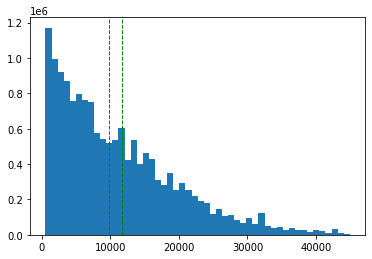

In [ ]:
print('Distancia de viajes con motivo de trabajo')
mask = (viajes_personas.PropositoAgregado=='Trabajo')
df = viajes_personas[mask].groupby('DistManhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('DistManhattan')
hist(df.DistManhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_personas[mask].groupby('Viaje').apply(lambda x: weighted_mean(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_personas[mask].groupby('Viaje').apply(lambda x: weighted_median(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
#Verde Promedio
#Rojo Mediana

#### **Viajes intra vs interzonales**

In [ ]:
print('% de viajes Inter e Intra zonales')
df = viajes_personas.groupby(['PropositoAgregado','Sexo','Intra_Inter_zona']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df.div(df.sum(axis=1), axis=0)

% de viajes Inter e Intra zonales


Intra_Inter_zona             Inter     Intra
PropositoAgregado Sexo                      
Estudio           Hombre  0.959567  0.040433
                  Mujer   0.959114  0.040886
Otro              Hombre  0.971414  0.028586
                  Mujer   0.972586  0.027414
Trabajo           Hombre  0.985978  0.014022
                  Mujer   0.985552  0.014448
Volver a casa     Hombre  1.000000       NaN
                  Mujer   0.998314  0.001686

In [ ]:
print('% de viajes Inter e Intra comunales')
df = viajes_personas.groupby(['PropositoAgregado','Sexo','Intra_Inter_comuna']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df.div(df.sum(axis=1), axis=0)

% de viajes Inter e Intra comunales


Intra_Inter_comuna           Inter     Intra
PropositoAgregado Sexo                      
Estudio           Hombre  0.529218  0.470782
                  Mujer   0.530127  0.469873
Otro              Hombre  0.547931  0.452069
                  Mujer   0.525687  0.474313
Trabajo           Hombre  0.770024  0.229976
                  Mujer   0.749504  0.250496
Volver a casa     Hombre  0.824710  0.175290
                  Mujer   0.708501  0.291499

In [ ]:
print('% de viajes Inter e Intra sector')
df = viajes_personas.groupby(['PropositoAgregado','Sexo','Intra_Inter_sector']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df.div(df.sum(axis=1), axis=0)

% de viajes Inter e Intra sector


Intra_Inter_sector           Inter     Intra
PropositoAgregado Sexo                      
Estudio           Hombre  0.347019  0.652981
                  Mujer   0.354869  0.645131
Otro              Hombre  0.326026  0.673974
                  Mujer   0.296844  0.703156
Trabajo           Hombre  0.567868  0.432132
                  Mujer   0.556140  0.443860
Volver a casa     Hombre  0.595525  0.404475
                  Mujer   0.534108  0.465892

### ¿Dónde se concentran las personas que utilizan cada modo de transporte en la ciudad para distintos propósitos?

<AxesSubplot:>

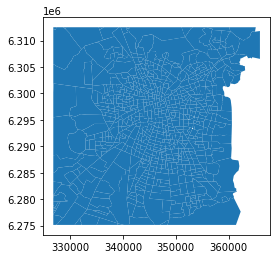

In [ ]:
from aves.features.geo import clip_area_geodataframe
bbox = [326815.3485,6275131.9514,365914.0887,6312532.9784]

zonas_en_caja = clip_area_geodataframe(city_shp.to_crs('epsg:32719'), bbox)
zonas_en_caja.plot()

In [ ]:
bounds = zonas_en_caja.to_crs('EPSG:4686').total_bounds

In [ ]:
import contextily as cx

scl_img, scl_ext = cx.bounds2raster(bounds[0], bounds[1], bounds[2], bounds[3], 
    "santiago_toner_12.tif",
    ll=True,
    source=cx.providers.Stamen.TonerBackground,
    zoom=12,
)

In [ ]:
viajes_personas.columns

Index(['Hogar_x', 'Persona', 'Viaje', 'Etapas', 'ComunaOrigen',
       'ComunaDestino', 'SectorOrigen', 'SectorDestino', 'ZonaOrigen',
       'ZonaDestino', 'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX',
       'DestinoCoordY', 'Proposito', 'PropositoAgregado', 'ModoAgregado',
       'ModoPriPub', 'HoraIni', 'HoraFin', 'TiempoViaje',
       'FactorLaboralNormal', 'FactorSabadoNormal', 'FactorDomingoNormal',
       'FactorLaboralEstival', 'FactorFindesemanaEstival', 'Periodo',
       'DistManhattan', 'DIA_HABIL', 'DIA_NOHABIL', 'PICO_HABIL',
       'PICO_NOHABIL', 'Intra_Inter_zona', 'Intra_Inter_sector',
       'Intra_Inter_comuna', 'Hogar_y', 'Sexo', 'Factor_LaboralNormal',
       'Factor_SabadoNormal', 'Factor_DomingoNormal', 'Factor_LaboralEstival',
       'Factor_FindesemanaEstival', 'TramoIngreso', 'PONDERADOR_CALIBRADO',
       'PONDERADOR_CALIBRADO_VIAJES'],
      dtype='object')

In [ ]:
viajes_personas.Proposito.unique()

array(['volver a casa', 'Al trabajo', 'Visitar a alguien', 'De compras',
       'Buscar o Dejar a alguien', 'Al estudio',
       'Otra actividad (especifique)', 'Recreación', 'Trámites',
       'Por trabajo', 'De salud', 'Por estudio', 'Buscar o dejar algo',
       'Comer o Tomar algo', nan], dtype=object)

In [ ]:
def transform_motives(row):
  if row['Proposito'] in ['Al trabajo', 'Por trabajo']:
    return 'Trabajo'
  elif row['Proposito']in ['Al estudio', 'Por estudio']:
    return 'Estudios'
  else:
    return row['Proposito']

In [ ]:
viajes_personas['proposito'] = viajes_personas.apply(lambda x: transform_motives(x), axis=1)

In [ ]:
viajes_personas.ModoAgregado.unique()

array(['Bus TS', 'Bus TS - Metro', 'Auto', 'Caminata', 'Otros', 'Taxi ',
       'Taxi Colectivo - Metro', 'Taxi Colectivo', 'Bus no TS - Metro',
       'Bus no TS', 'Bicicleta', 'Otros - Metro', 'Bus TS - Bus no TS',
       'Otros - Bus TS - Metro', 'Metro', 'Otros - Bus TS',
       'Auto - Metro', 'Taxi - Metro'], dtype=object)

In [ ]:
from aves.features.geo import to_point_geodataframe
origenes_viajes = to_point_geodataframe(viajes_personas, 'OrigenCoordX' , 'OrigenCoordY', crs='epsg:32719')
destinos_viajes = to_point_geodataframe(viajes_personas, 'DestinoCoordX', 'DestinoCoordY', crs='epsg:32719')

In [ ]:
from aves.features.geo import clip_point_geodataframe

origenes_viajes = origenes_viajes[(origenes_viajes['Viaje'].isin(destinos_viajes['Viaje']))]
origenes_viajes = clip_point_geodataframe(origenes_viajes, zonas_en_caja.total_bounds)
destinos_viajes = destinos_viajes[(destinos_viajes['Viaje'].isin(origenes_viajes['Viaje']))]
destinos_viajes = clip_point_geodataframe(destinos_viajes, zonas_en_caja.total_bounds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


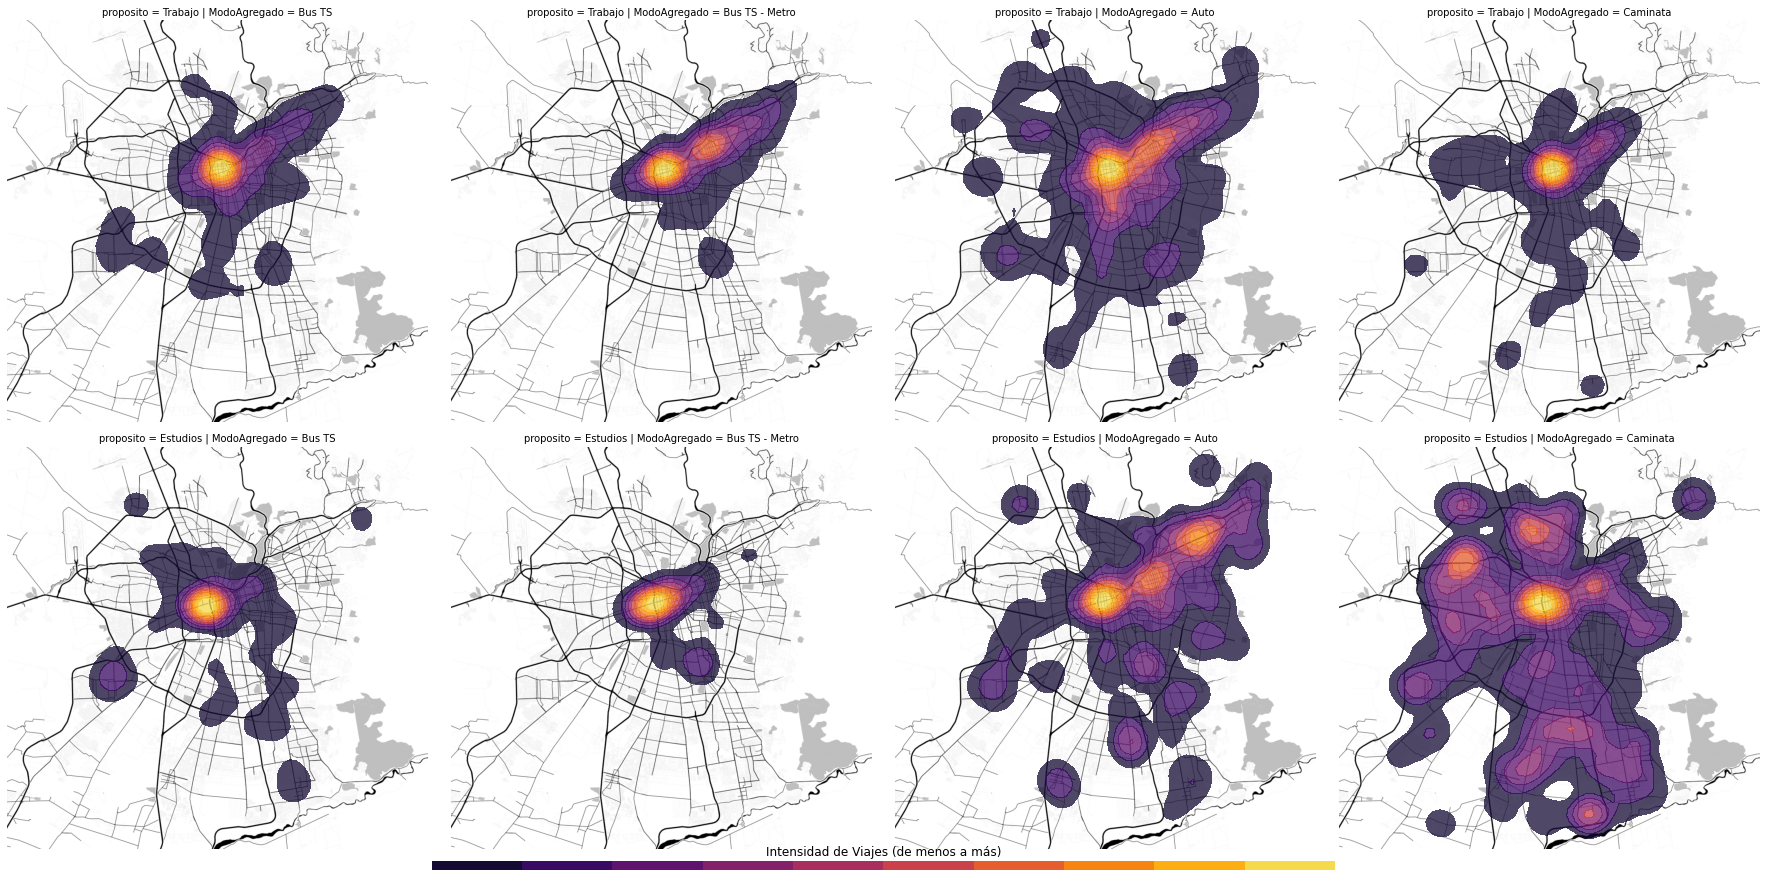

In [ ]:
from aves.visualization.figures import GeoFacetGrid

from aves.visualization.maps import heat_map

grid = GeoFacetGrid(
    origenes_viajes,
    context=zonas_en_caja,
    row="proposito",
    col="ModoAgregado",
    row_order=["Trabajo", "Estudios"],
    col_order=['Bus TS', 'Bus TS - Metro', 'Auto', 'Caminata'],
    height=6,
    hue="ModoAgregado"
)
grid.add_basemap("santiago_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="PONDERADOR_CALIBRADO_VIAJES",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=1000,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)

grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
#grid.set_title("Viajes a trabajar y a estudiar de acuerdo al modo de transporte")
grid.fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


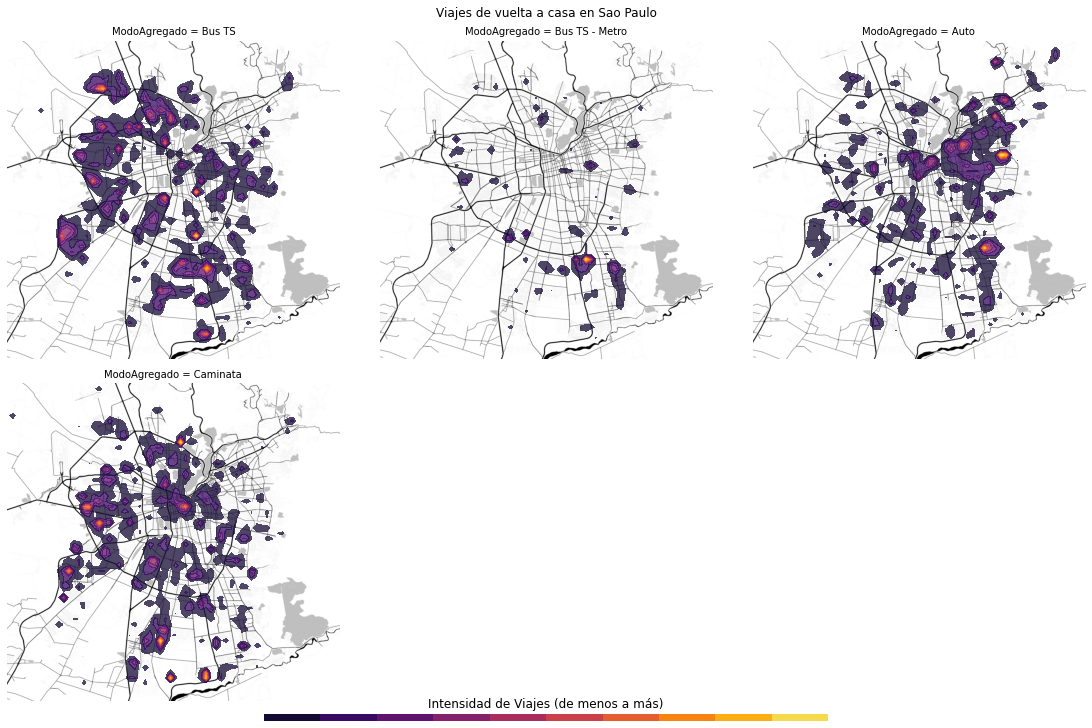

In [ ]:
grid = GeoFacetGrid(
    destinos_viajes[destinos_viajes.proposito=='volver a casa'],
    context=zonas_en_caja,
    #row="MOTIVOVIAJE",
    col="ModoAgregado",
    col_wrap=3,
    row_order=["volver a casa"],
    col_order=['Bus TS', 'Bus TS - Metro', 'Auto', 'Caminata'],
    height=5,
    hue="ModoAgregado"
)
grid.add_basemap("santiago_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1, alpha=0.5)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="PONDERADOR_CALIBRADO_VIAJES",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.005,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)
grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
grid.set_title("Viajes de vuelta a casa en Santiago")
grid.fig.tight_layout()

#### ¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [ ]:
viajes_todos = origenes_viajes[(pd.notnull(origenes_viajes.PONDERADOR_CALIBRADO_VIAJES)) &
                                (origenes_viajes.DistManhattan > 0)].drop_duplicates(subset=['Persona'], keep='first')

In [ ]:
viajes_habiles = origenes_viajes[(origenes_viajes.DIA_HABIL == 'Si') &
                                (pd.notnull(origenes_viajes.PONDERADOR_CALIBRADO_VIAJES)) &
                                (origenes_viajes.DistManhattan > 0)].drop_duplicates(subset=['Persona'], keep='first')

In [ ]:
viajes_trabajo = origenes_viajes[(origenes_viajes.proposito == 'Trabajo') &
                                (pd.notnull(origenes_viajes.PONDERADOR_CALIBRADO_VIAJES)) &
                                (origenes_viajes.DistManhattan > 0)].drop_duplicates(subset=['Persona'], keep='first')
                                
print(len(viajes_trabajo), viajes_trabajo.PONDERADOR_CALIBRADO_VIAJES.sum())

15413 7437088.08865577


In [ ]:
distancia_zonas_mean = (viajes_trabajo
                   .groupby(['ZonaOrigen'])
                   .apply(lambda x: weighted_mean(x, 'DistManhattan', 'PONDERADOR_CALIBRADO_VIAJES'))
                   .rename('media_distancia_al_trabajo')
)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


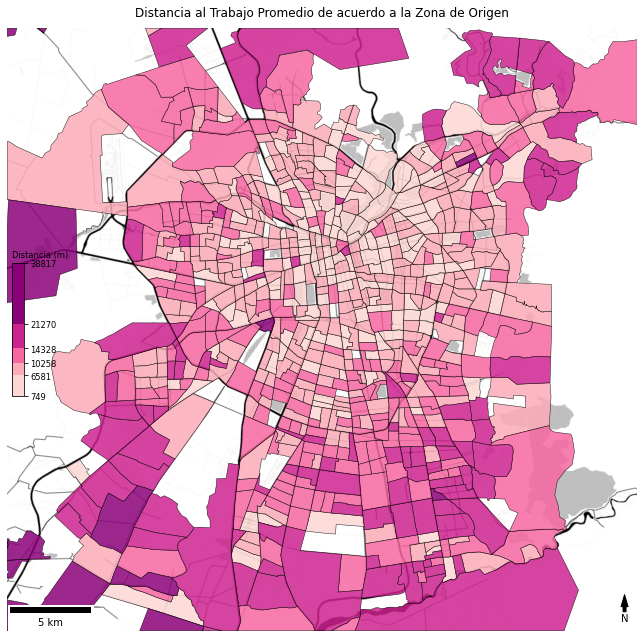

In [ ]:
from aves.visualization.maps import choropleth_map
grid = GeoFacetGrid(zonas_en_caja.set_index('Zona').join(distancia_zonas_mean, how="left"), height=9)
grid.add_basemap("santiago_toner_12.tif")
grid.add_layer(
    choropleth_map,
    "media_distancia_al_trabajo",
    k=5,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    palette="RdPu",
    alpha=0.85,
    cbar_args=dict(
        label="Distancia (m)",
        height="22%",
        width="2%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ),
)
grid.add_map_elements()
grid.set_title("Distancia al Trabajo Promedio de acuerdo a la Zona de Origen")
grid.tight_layout()

In [ ]:
matriz_zonas = (viajes_trabajo[(viajes_trabajo['ZonaOrigen'] != viajes_trabajo['ZonaDestino'])
                            
                             & (viajes_trabajo['ZonaOrigen'].isin(zonas_en_caja.Zona))
                             & (viajes_trabajo['ZonaDestino'].isin(zonas_en_caja.Zona))]
                    .groupby(['ZonaOrigen', 'ZonaDestino'])
                    .agg(n_viajes=('PONDERADOR_CALIBRADO_VIAJES', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + 'matriz_zonas_trabajo_santiago2012.csv', index=False)

In [ ]:
matriz_zonas = (viajes_todos[(viajes_todos['ZonaOrigen'] != viajes_todos['ZonaDestino'])
                             & (viajes_todos['ZonaOrigen'].isin(zonas_en_caja.Zona))
                             & (viajes_todos['ZonaDestino'].isin(zonas_en_caja.Zona))]
                    .groupby(['ZonaOrigen', 'ZonaDestino'])
                    .agg(n_viajes=('PONDERADOR_CALIBRADO_VIAJES', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + 'matriz_zonas_todos_santiago2012.csv', index=False)

In [ ]:
matriz_zonas = (viajes_habiles[(viajes_habiles['ZonaOrigen'] != viajes_habiles['ZonaDestino'])
                             & (viajes_habiles['ZonaOrigen'].isin(zonas_en_caja.Zona))
                             & (viajes_habiles['ZonaDestino'].isin(zonas_en_caja.Zona))]
                    .groupby(['ZonaOrigen', 'ZonaDestino'])
                    .agg(n_viajes=('PONDERADOR_CALIBRADO_VIAJES', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + 'matriz_zonas_habiles_santiago2012.csv', index=False)

In [ ]:
matriz_zonas = matriz_zonas[matriz_zonas['cumsum_viajes'] <= 0.8]

In [ ]:
merged_zones = zonas_en_caja.dissolve('Zona')

In [ ]:
from aves.models.network import Network
from aves.visualization.networks import NodeLink

zone_od_network = Network.from_edgelist(
    matriz_zonas, source="ZonaOrigen", target="ZonaDestino", weight="n_viajes"
)

In [ ]:
zone_nodelink = NodeLink(zone_od_network)
zone_nodelink.layout_nodes(method="geographical", geodataframe=merged_zones)
zone_nodelink.set_node_drawing("plain", weights=zone_od_network.node_degree("in"))
zone_nodelink.set_edge_drawing(method="origin-destination")

In [ ]:
def plot_network(ax, geo_data, *args, **kwargs):
    zone_nodelink.plot(ax, *args, **kwargs)

In [ ]:
zone_nodelink.bundle_edges(
    method="force-directed", K=1, S=500, I=30, compatibility_threshold=0.65, C=6
)

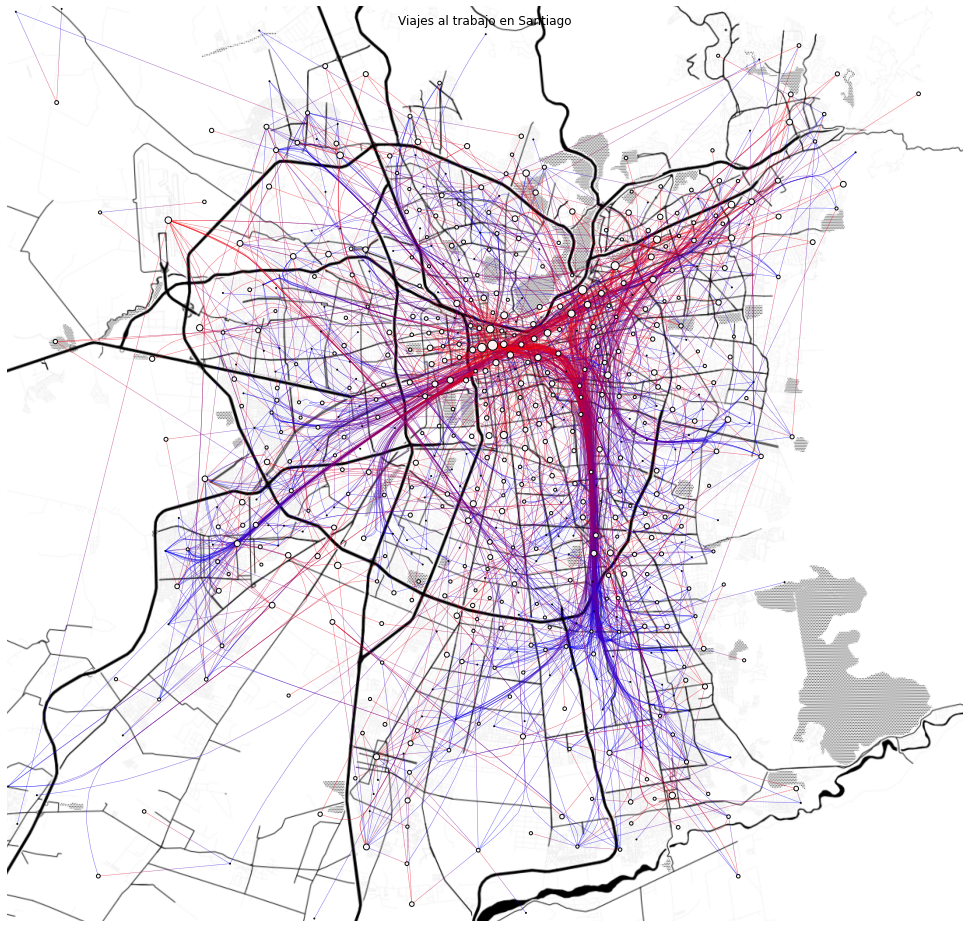

In [ ]:
grid = GeoFacetGrid(zonas_en_caja, height=13)
grid.add_basemap("santiago_toner_12.tif")
#grid.add_layer(city_shp_filt,facecolor='white', edgecolor='grey', alpha=0.25)
grid.add_layer(
    plot_network,
    nodes=dict(color="white", edgecolor="black", node_size=100, alpha=0.95),
    edges=dict(linewidth=0.5, alpha=0.55),
)
grid.set_title("Viajes al trabajo en Santiago")